In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import signal
import scipy.optimize 

#Some plot parameters
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18

In [2]:
#Read in data file

fprawdata_df = pd.read_csv('FED3_Trial_SP 7-2 _FP2021-10-29T14_27_06.csv',
                           sep=',',index_col=False) #change file for each mouse! brings data in to the journal

#Read in the keys file for time stamps
fprawdatakey_df = pd.read_csv('FED3_Trial_SP 7-2 _Pellet RetrivalTimestamp 2021-10-29T14_27_05.csv',
                            sep=',',index_col=False, names = ['Timestamp', 'Value.Seconds','Value.Value'])

In [3]:
fprawdata_df

,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
0,0,14281.916544,0,0,0,0,0,0,0.003922,0.003922,0.003922,0.003922
1,1,14281.941504,2,0,0,0,0,0,0.017682,0.018747,0.016088,0.023331
2,2,14281.966496,1,0,0,0,0,0,0.013220,0.014872,0.014715,0.016816
3,3,14281.991520,4,0,0,0,0,0,0.891975,0.654948,0.065040,0.089288
4,4,14282.016512,2,0,0,0,0,0,0.017689,0.018826,0.016104,0.023400
...,...,...,...,...,...,...,...,...,...,...,...,...
371262,371262,23563.378656,4,0,0,0,0,0,0.872845,0.640512,0.060942,0.083000
371263,371263,23563.403680,2,0,0,0,0,0,0.015371,0.016282,0.014387,0.020680
371264,371264,23563.428672,1,0,0,0,0,0,0.009625,0.009243,0.012763,0.014014
371265,371265,23563.453664,4,0,0,0,0,0,0.873002,0.640543,0.061029,0.083056


In [4]:
fprawdatakey_df

,Timestamp,Value.Seconds,Value.Value
0,Timestamp,Value.Seconds,Value.Value
1,17122.01392,17122.03904,True
2,17122.21392,17122.23904,False
3,17214.287936,17214.332576,True
4,17214.487936,17214.532544,False
5,17304.511968,17304.554048,True
6,17304.711968,17304.754048,False
7,17373.236288,17373.276896,True
8,17373.436288,17373.476864,False
9,17478.710304,17478.753184,True


# Manual Deinterleaving

In [5]:
# some quick numbers on the appropriate number of data points to grab around those time points
# 1 minute = 1200 frames
# 5 minutes = 6000 frames
# 10 minutes = 12000 frames
# 15 minutes = 18000 frames
# 20 minutes = 24000 frames
# 25 minutes = 30000 frames
# 30 minutes = 36000 frames

In [6]:
fprawdata410_df = fprawdata_df.iloc[6002::3,:]
fprawdata470_df = fprawdata_df.iloc[6004::3,:]
fprawdata560_df = fprawdata_df.iloc[6003::3,:]
fprawdata410_df.reset_index(inplace=True) #Will reset the index with new row numbers
fprawdata470_df.reset_index(inplace=True)
fprawdata560_df.reset_index(inplace=True)

In [7]:
fprawdata410_df

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
0,6002,6002,14431.964928,1,0,0,0,0,0,0.011952,0.012412,0.013916,0.015620
1,6005,6005,14432.039872,1,0,0,0,0,0,0.011963,0.012446,0.014014,0.015621
2,6008,6008,14432.114880,1,0,0,0,0,0,0.011946,0.012460,0.013973,0.015636
3,6011,6011,14432.189888,1,0,0,0,0,0,0.011919,0.012416,0.013971,0.015678
4,6014,6014,14432.264896,1,0,0,0,0,0,0.011863,0.012380,0.013957,0.015670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121750,371252,371252,23563.128672,1,0,0,0,0,0,0.009592,0.009239,0.012748,0.013944
121751,371255,371255,23563.203680,1,0,0,0,0,0,0.009641,0.009236,0.012756,0.013955
121752,371258,371258,23563.278688,1,0,0,0,0,0,0.009622,0.009261,0.012805,0.013985
121753,371261,371261,23563.353664,1,0,0,0,0,0,0.009632,0.009256,0.012783,0.013960


In [8]:
fprawdata470_df

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
0,6004,6004,14432.014880,2,0,0,0,0,0,0.016383,0.018030,0.015622,0.022550
1,6007,6007,14432.089888,2,0,0,0,0,0,0.016475,0.018042,0.015630,0.022519
2,6010,6010,14432.164864,2,0,0,0,0,0,0.016448,0.018024,0.015587,0.022578
3,6013,6013,14432.239872,2,0,0,0,0,0,0.016438,0.018032,0.015627,0.022535
4,6016,6016,14432.314880,2,0,0,0,0,0,0.016402,0.018021,0.015628,0.022526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121750,371254,371254,23563.178688,2,0,0,0,0,0,0.015413,0.016256,0.014343,0.020664
121751,371257,371257,23563.253664,2,0,0,0,0,0,0.015449,0.016239,0.014308,0.020607
121752,371260,371260,23563.328672,2,0,0,0,0,0,0.015382,0.016275,0.014330,0.020630
121753,371263,371263,23563.403680,2,0,0,0,0,0,0.015371,0.016282,0.014387,0.020680


In [9]:
fprawdata560_df

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
0,6003,6003,14431.989920,4,0,0,0,0,0,0.876577,0.643770,0.064229,0.086752
1,6006,6006,14432.064896,4,0,0,0,0,0,0.876707,0.643666,0.064285,0.086790
2,6009,6009,14432.139872,4,0,0,0,0,0,0.876400,0.643818,0.064203,0.086672
3,6012,6012,14432.214880,4,0,0,0,0,0,0.876492,0.643782,0.064265,0.086658
4,6015,6015,14432.289888,4,0,0,0,0,0,0.876642,0.643924,0.064239,0.086754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121750,371253,371253,23563.153664,4,0,0,0,0,0,0.872918,0.640532,0.060973,0.083014
121751,371256,371256,23563.228672,4,0,0,0,0,0,0.873018,0.640359,0.060988,0.083009
121752,371259,371259,23563.303680,4,0,0,0,0,0,0.872858,0.640385,0.060984,0.083011
121753,371262,371262,23563.378656,4,0,0,0,0,0,0.872845,0.640512,0.060942,0.083000


# Plot Raw Data

In [10]:
gcamp_raw_signalright = fprawdata470_df['Region0G']
gcamp_raw_referenceright = fprawdata410_df['Region0G']

rcamp_raw_signalright = fprawdata560_df['Region2R']
rcamp_raw_referenceright = fprawdata410_df['Region2R']

gcamp_raw_signalleft = fprawdata470_df['Region1G']
gcamp_raw_referenceleft = fprawdata410_df['Region1G']

rcamp_raw_signalleft = fprawdata560_df['Region3R']
rcamp_raw_referenceleft = fprawdata410_df['Region3R']

x = fprawdata410_df['Timestamp']


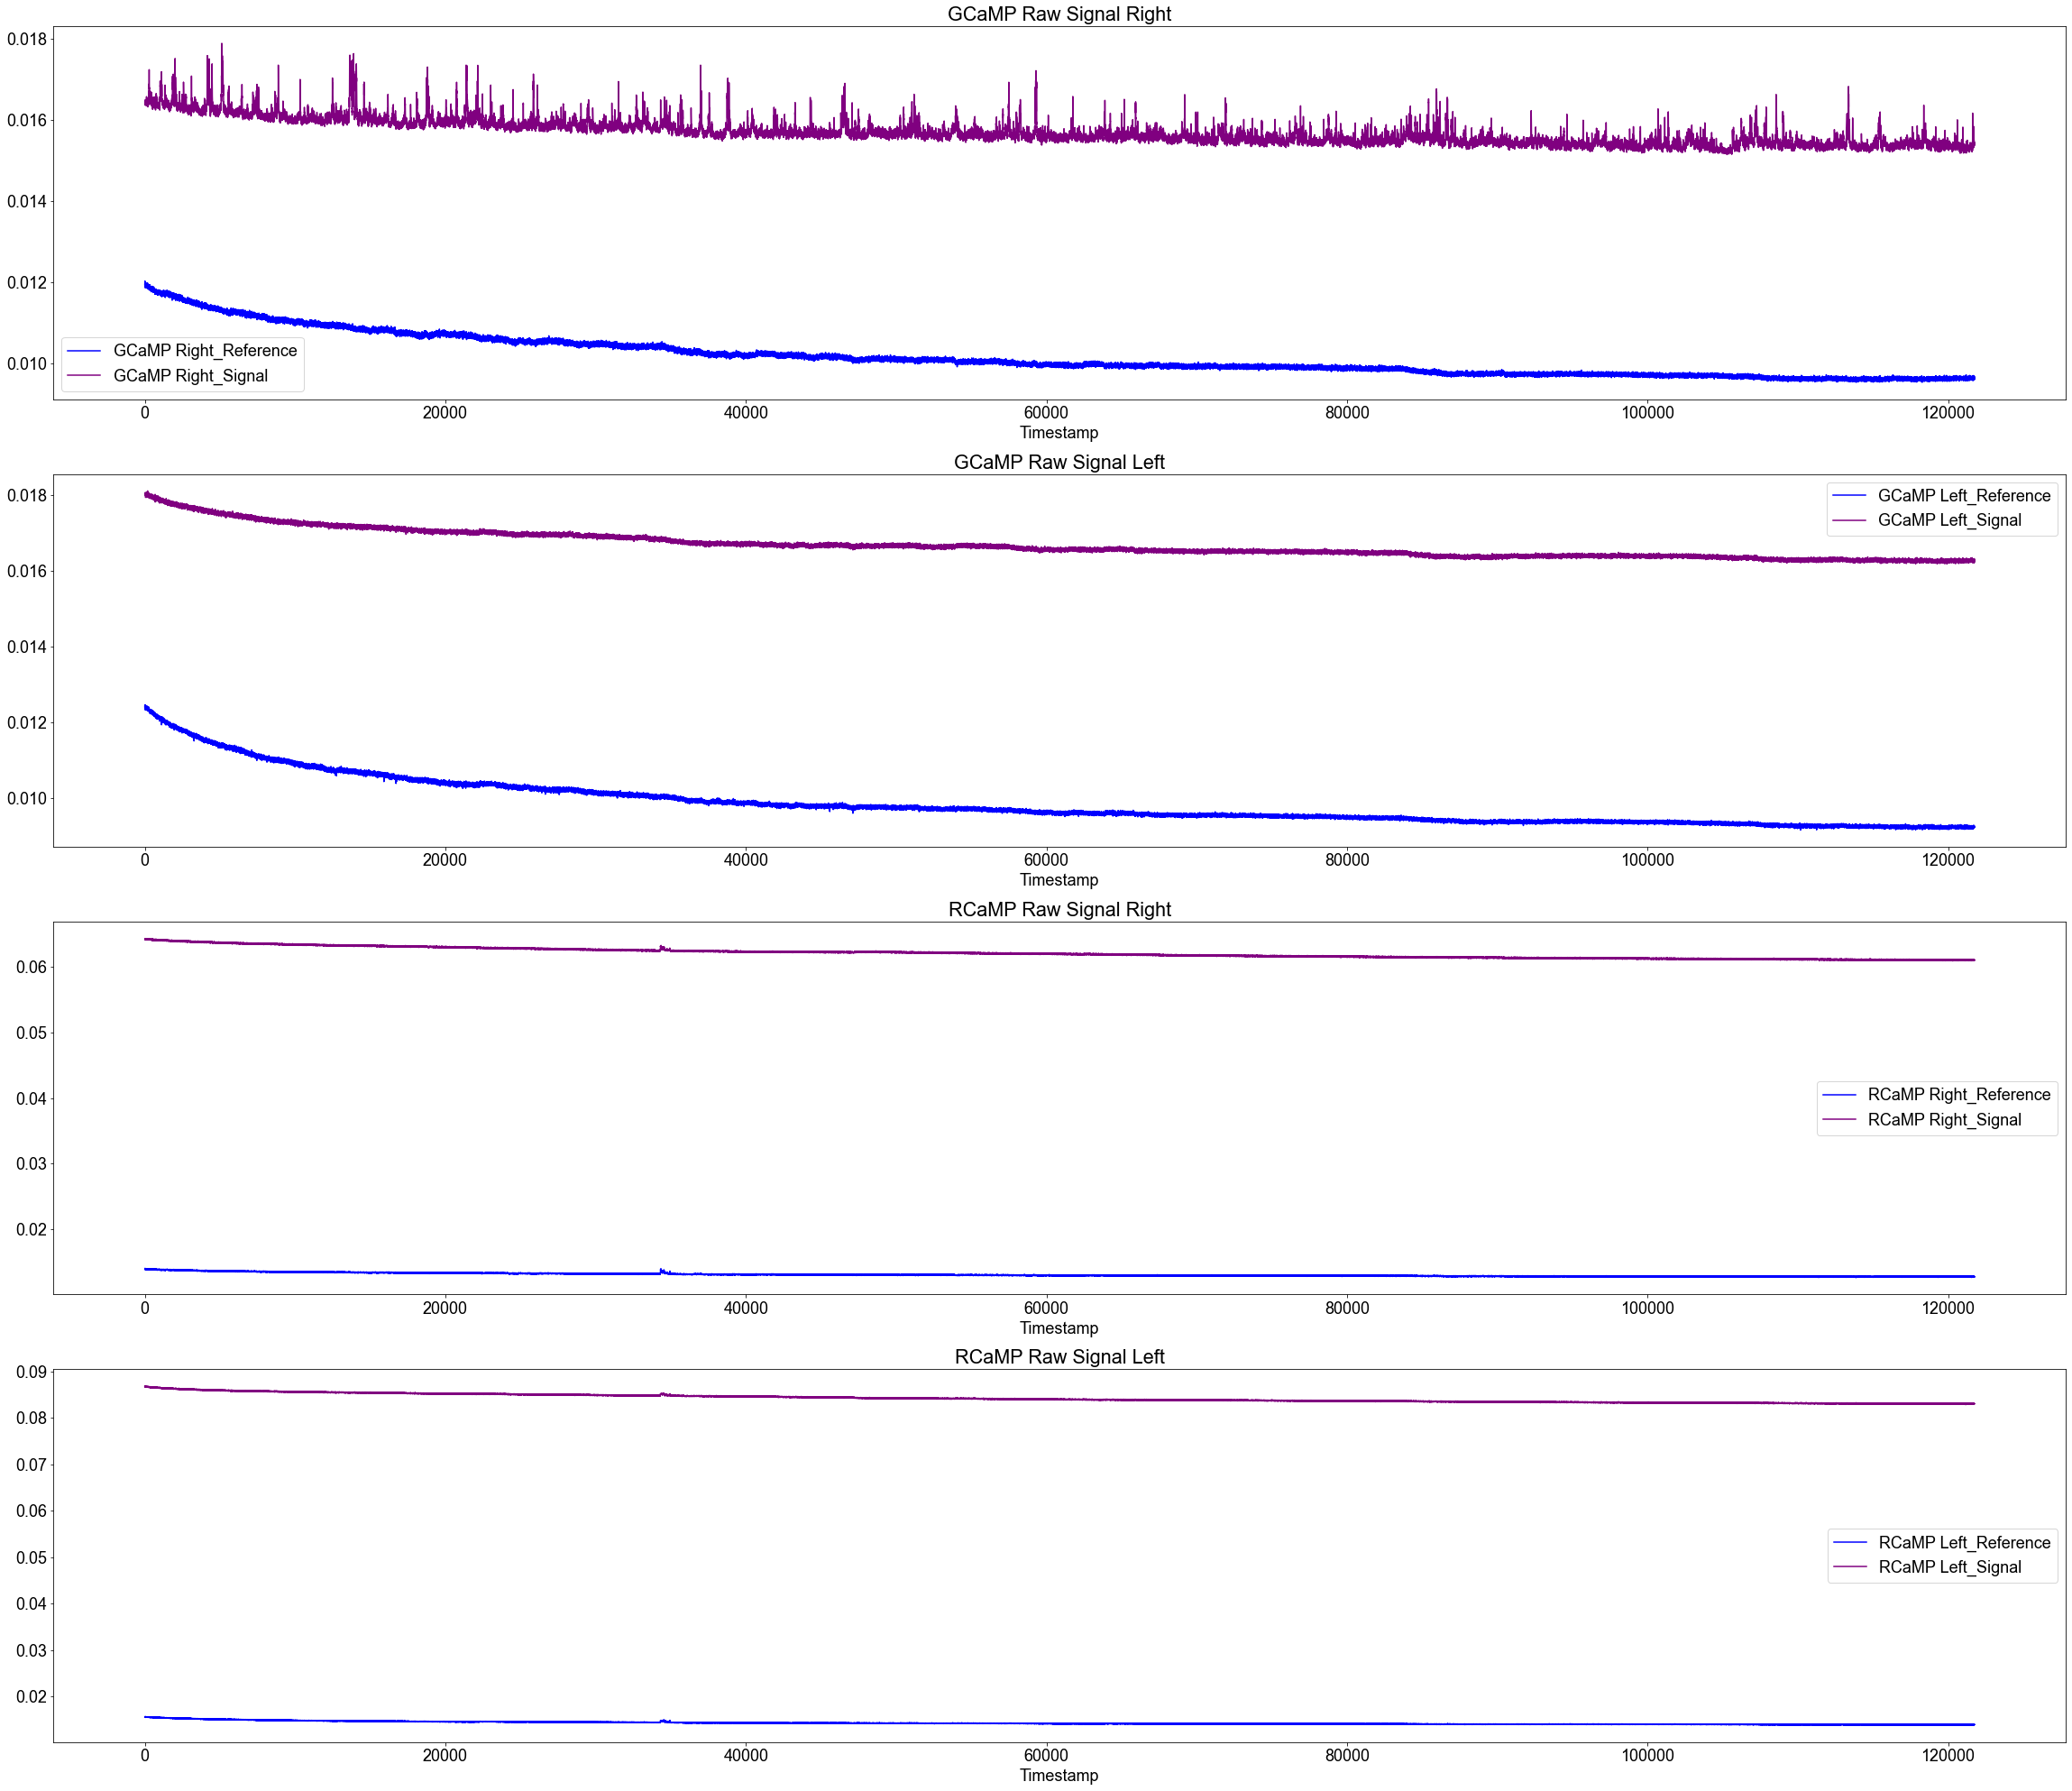

In [11]:
fig = plt.figure(figsize=(40, 35))
ax1 = fig.add_subplot(411,label='Right')
ax1.plot(gcamp_raw_referenceright,'blue',linewidth=1.5,label='GCaMP Right_Reference')
ax1.plot(gcamp_raw_signalright,'purple',linewidth=1.5,label='GCaMP Right_Signal')
ax1.set_xlabel('Timestamp')
plt.title('GCaMP Raw Signal Right')
plt.legend()

ax2 = fig.add_subplot(412,label='Left')
ax2.plot(gcamp_raw_referenceleft,'blue',linewidth=1.5,label='GCaMP Left_Reference')
ax2.plot(gcamp_raw_signalleft,'purple',linewidth=1.5,label='GCaMP Left_Signal')
ax2.set_xlabel('Timestamp')
plt.title('GCaMP Raw Signal Left')
plt.legend()

ax3 = fig.add_subplot(413,label='Right')
ax3.plot(rcamp_raw_referenceright,'blue',linewidth=1.5,label='RCaMP Right_Reference')
ax3.plot(rcamp_raw_signalright,'purple',linewidth=1.5,label='RCaMP Right_Signal')
ax3.set_xlabel('Timestamp')
plt.title('RCaMP Raw Signal Right')
plt.legend()

ax4 = fig.add_subplot(414,label='Left')
ax4.plot(rcamp_raw_referenceleft,'blue',linewidth=1.5,label='RCaMP Left_Reference')
ax4.plot(rcamp_raw_signalleft,'purple',linewidth=1.5,label='RCaMP Left_Signal')
ax4.set_xlabel('Timestamp')
plt.title('RCaMP Raw Signal Left')
plt.legend()

# Smooth the Signal

In [12]:
def smooth_signal(x,window_len=10,window='flat'):

    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    The code taken from: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
                'flat' window will produce a moving average smoothing.

    output:
        the smoothed signal        
    """

    import numpy as np

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': # Moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')

    return y[(int(window_len/2)-1):-int(window_len/2)]

In [13]:
#Smooth Signal 
smooth_win = 20
gcamp_smooth_signalright = smooth_signal(gcamp_raw_signalright, smooth_win)
rcamp_smooth_signalright = smooth_signal(rcamp_raw_signalright, smooth_win)
gcamp_smooth_referenceright = smooth_signal(gcamp_raw_referenceright, smooth_win)
rcamp_smooth_referenceright = smooth_signal(rcamp_raw_referenceright, smooth_win)
gcamp_smooth_signalleft = smooth_signal(gcamp_raw_signalleft, smooth_win)
rcamp_smooth_signalleft = smooth_signal(rcamp_raw_signalleft, smooth_win)
gcamp_smooth_referenceleft = smooth_signal(gcamp_raw_referenceleft, smooth_win)
rcamp_smooth_referenceleft = smooth_signal(rcamp_raw_referenceleft, smooth_win)

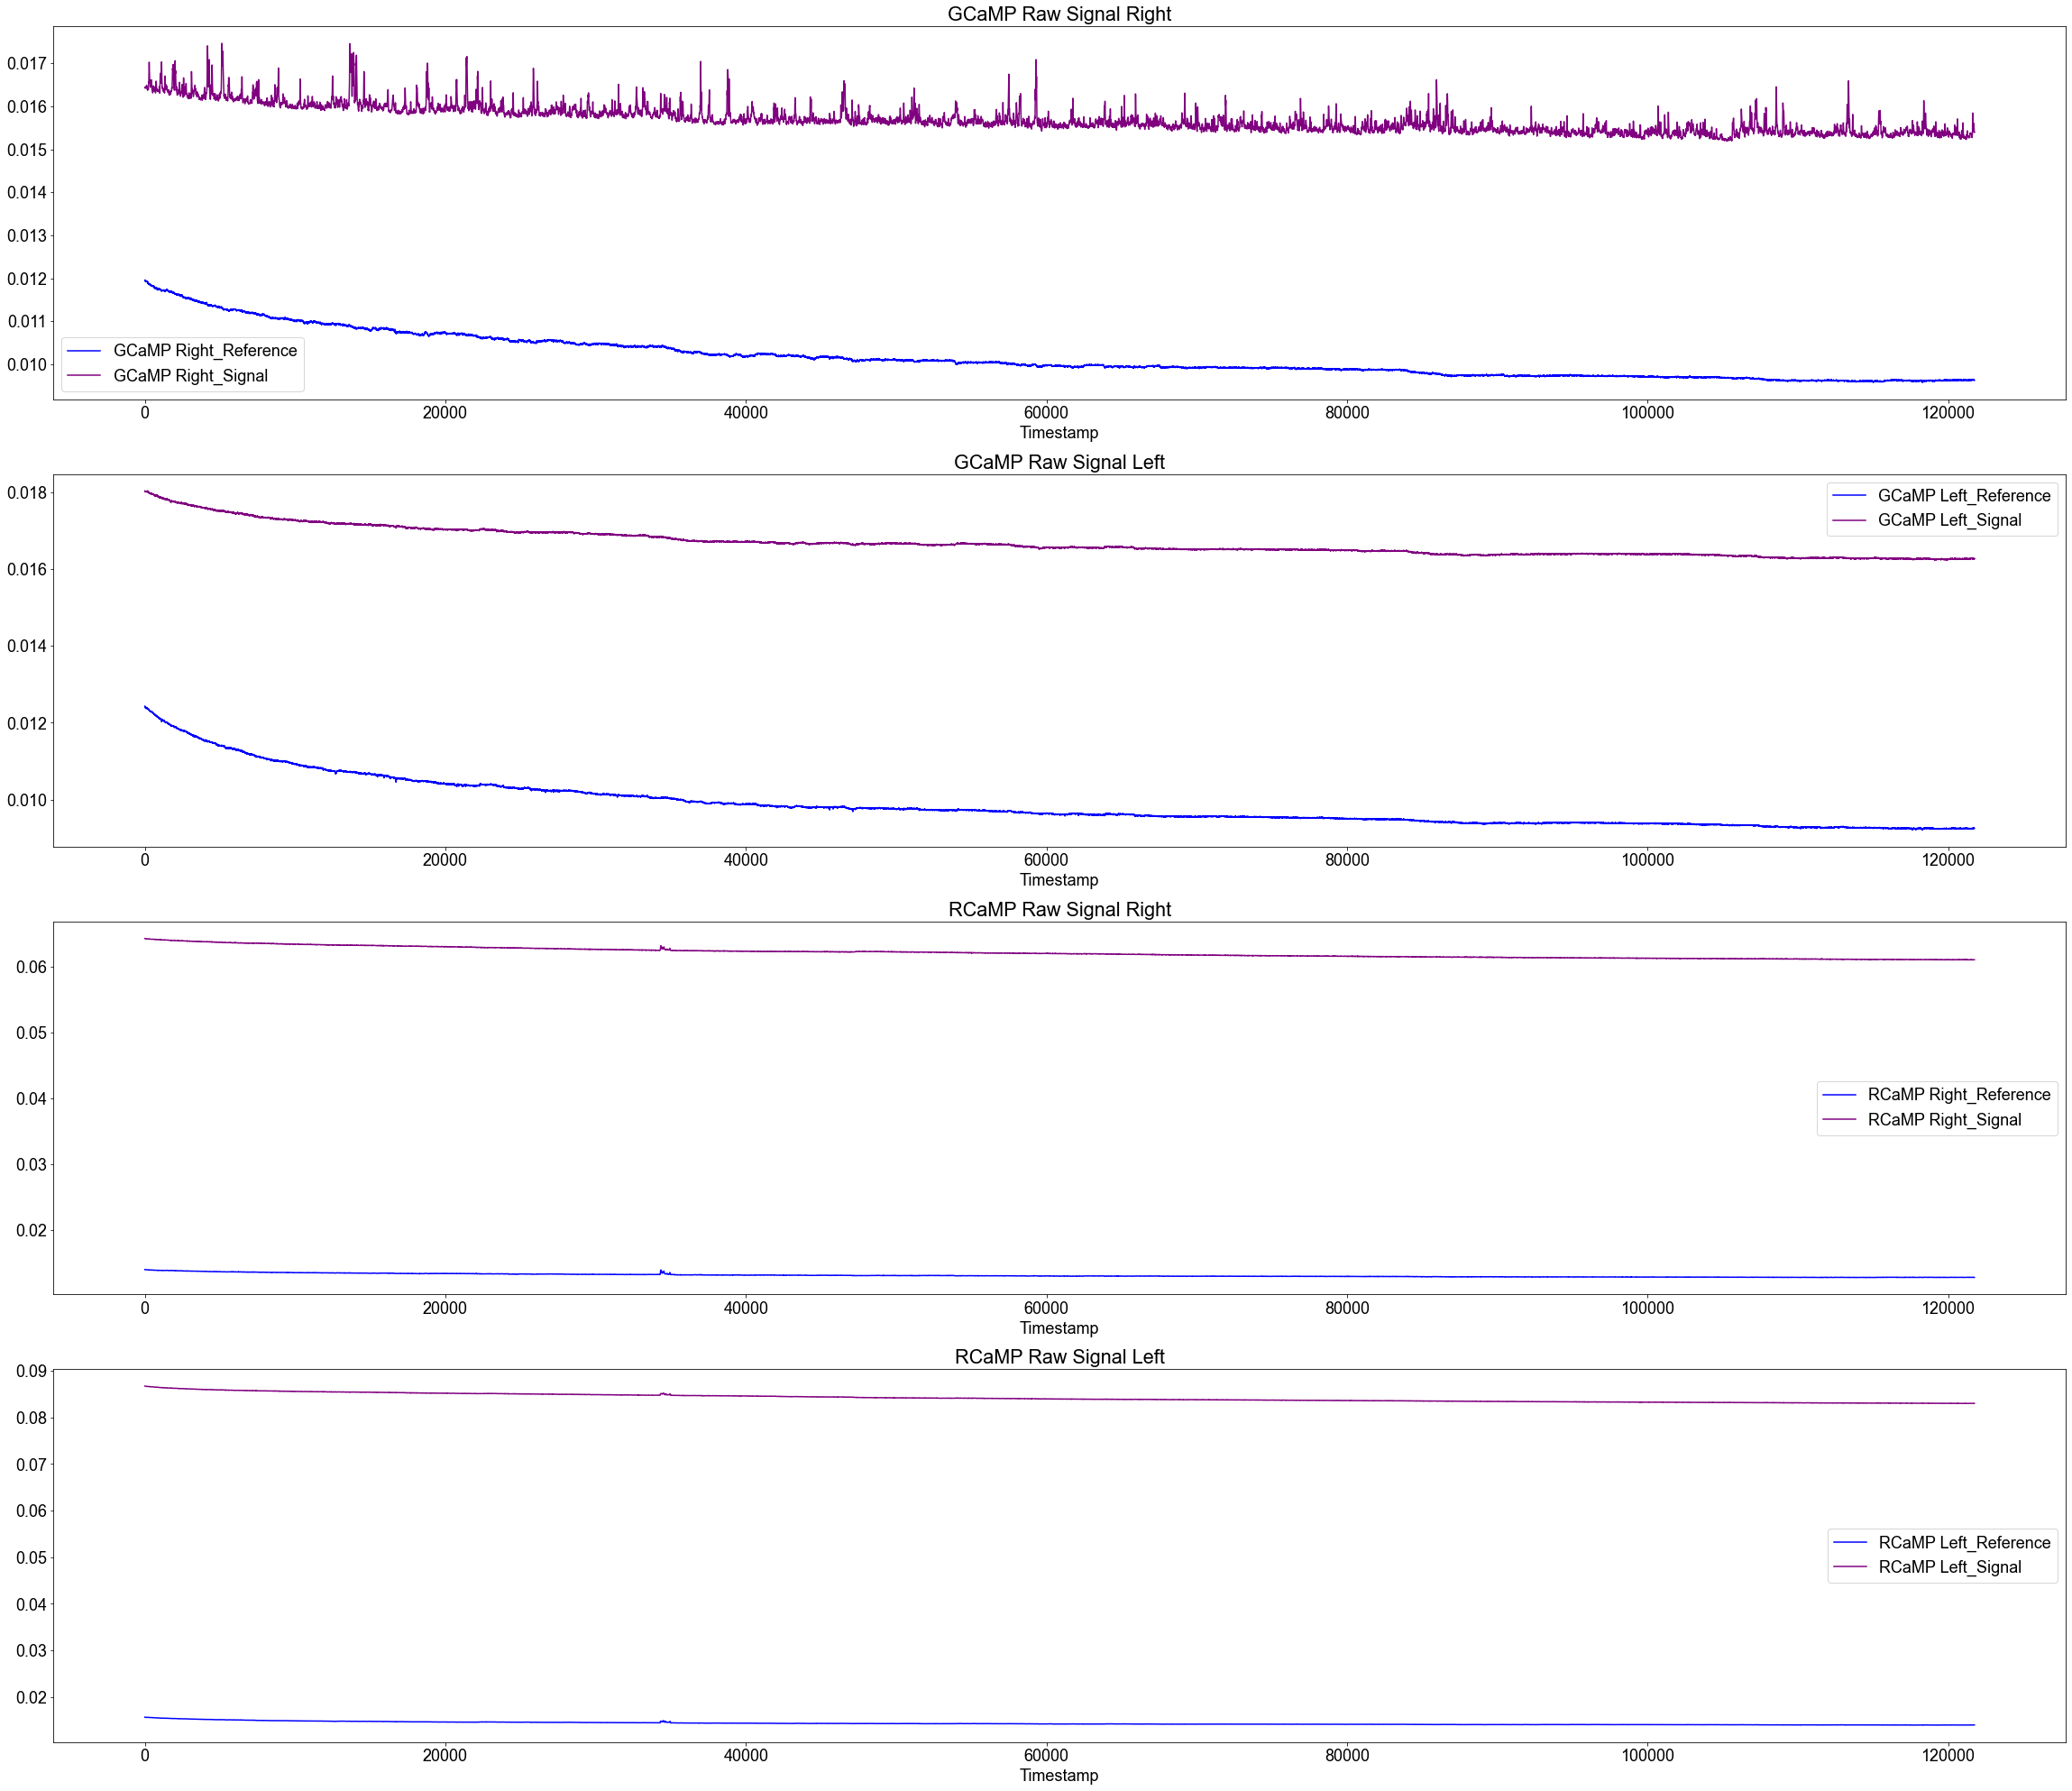

In [14]:
fig = plt.figure(figsize=(40, 35))
ax1 = fig.add_subplot(411,label='Right')
ax1.plot(gcamp_smooth_referenceright,'blue',linewidth=1.5,label='GCaMP Right_Reference')
ax1.plot(gcamp_smooth_signalright,'purple',linewidth=1.5,label='GCaMP Right_Signal')
ax1.set_xlabel('Timestamp')
plt.title('GCaMP Raw Signal Right')
plt.legend()

ax2 = fig.add_subplot(412,label='Left')
ax2.plot(gcamp_smooth_referenceleft,'blue',linewidth=1.5,label='GCaMP Left_Reference')
ax2.plot(gcamp_smooth_signalleft,'purple',linewidth=1.5,label='GCaMP Left_Signal')
ax2.set_xlabel('Timestamp')
plt.title('GCaMP Raw Signal Left')
plt.legend()

ax3 = fig.add_subplot(413,label='Right')
ax3.plot(rcamp_smooth_referenceright,'blue',linewidth=1.5,label='RCaMP Right_Reference')
ax3.plot(rcamp_smooth_signalright,'purple',linewidth=1.5,label='RCaMP Right_Signal')
ax3.set_xlabel('Timestamp')
plt.title('RCaMP Raw Signal Right')
plt.legend()

ax4 = fig.add_subplot(414,label='Left')
ax4.plot(rcamp_smooth_referenceleft,'blue',linewidth=1.5,label='RCaMP Left_Reference')
ax4.plot(rcamp_smooth_signalleft,'purple',linewidth=1.5,label='RCaMP Left_Signal')
ax4.set_xlabel('Timestamp')
plt.title('RCaMP Raw Signal Left')
plt.legend()

# Divide 470 & 560 by 415 to correct signals

In [15]:
gcamp_corrected_signalright = gcamp_smooth_signalright/gcamp_smooth_referenceright
gcamp_corrected_signalleft = gcamp_smooth_signalleft/gcamp_smooth_referenceleft

gcamp_corrected_signalright_df = pd.Series(gcamp_corrected_signalright) #will read the trace into an editable dataframe
gcamp_corrected_signalleft_df = pd.Series(gcamp_corrected_signalleft) #will read the trace into an editable dataframe

rcamp_corrected_signalright = rcamp_smooth_signalright/rcamp_smooth_referenceright
rcamp_corrected_signalleft = rcamp_smooth_signalleft/rcamp_smooth_referenceleft

rcamp_corrected_signalright_df = pd.Series(rcamp_corrected_signalright) #will read the trace into an editable dataframe
rcamp_corrected_signalleft_df = pd.Series(rcamp_corrected_signalleft) #will read the trace into an editable dataframe

# Find Timestamp

In [16]:
fprawdatakey_df

,Timestamp,Value.Seconds,Value.Value
0,Timestamp,Value.Seconds,Value.Value
1,17122.01392,17122.03904,True
2,17122.21392,17122.23904,False
3,17214.287936,17214.332576,True
4,17214.487936,17214.532544,False
5,17304.511968,17304.554048,True
6,17304.711968,17304.754048,False
7,17373.236288,17373.276896,True
8,17373.436288,17373.476864,False
9,17478.710304,17478.753184,True


In [17]:
pellet1 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[1]))).argmin()
print(pellet1)
#Take caution because below I show that fprawdata560 recieves input before ^410 so this means that input will not consistently
#happen on the same ledstate
#Upon further update from other SP experiments, we seem to consistently recieve our BIN Output from FED3 starting with the l560
# and L415 recieves it last 

35868


In [18]:
fprawdata470_df[35860:35870]

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
35860,113584,113584,17121.488960,2,0,0,0,0,0,0.015747,0.016754,0.014904,0.021351
35861,113587,113587,17121.563968,2,0,0,0,0,0,0.015736,0.016759,0.014880,0.021335
35862,113590,113590,17121.638976,2,0,0,0,0,0,0.015757,0.016746,0.014874,0.021305
35863,113593,113593,17121.713952,2,0,0,0,0,0,0.015750,0.016799,0.014876,0.021370
35864,113596,113596,17121.788960,2,0,0,0,0,0,0.015751,0.016738,0.014886,0.021389
35865,113599,113599,17121.863968,2,0,0,0,0,0,0.015709,0.016789,0.014878,0.021338
35866,113602,113602,17121.938976,2,0,0,0,0,0,0.015757,0.016773,0.014878,0.021348
35867,113605,113605,17122.013920,2,0,0,0,0,0,0.015742,0.016785,0.014869,0.021361
35868,113608,113608,17122.088928,2,0,0,0,1,0,0.015715,0.016794,0.014882,0.021369
35869,113611,113611,17122.163936,2,0,0,0,1,0,0.015687,0.016782,0.014832,0.021337


In [19]:
fprawdata410_df[35860:35870]

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
35860,113582,113582,17121.438976,1,0,0,0,0,0,0.010367,0.009987,0.013135,0.014395
35861,113585,113585,17121.513952,1,0,0,0,0,0,0.010313,0.009988,0.013173,0.014450
35862,113588,113588,17121.588960,1,0,0,0,0,0,0.010298,0.010025,0.013145,0.014342
35863,113591,113591,17121.663968,1,0,0,0,0,0,0.010267,0.009975,0.013233,0.014428
35864,113594,113594,17121.738976,1,0,0,0,0,0,0.010346,0.009986,0.013159,0.014415
35865,113597,113597,17121.813952,1,0,0,0,0,0,0.010288,0.009958,0.013190,0.014430
35866,113600,113600,17121.888960,1,0,0,0,0,0,0.010308,0.009983,0.013206,0.014419
35867,113603,113603,17121.963968,1,0,0,0,0,0,0.010294,0.009961,0.013149,0.014404
35868,113606,113606,17122.038944,1,0,0,0,0,0,0.010313,0.009966,0.013232,0.014466
35869,113609,113609,17122.113920,1,0,0,0,1,0,0.010296,0.009964,0.013158,0.014432


In [20]:
fprawdata560_df[35860:35870]

,index,FrameCounter,Timestamp,LedState,Stimulation,Output0,Output1,Input0,Input1,Region0G,Region1G,Region2R,Region3R
35860,113583,113583,17121.463968,4,0,0,0,0,0,0.874328,0.641991,0.062387,0.084758
35861,113586,113586,17121.538944,4,0,0,0,0,0,0.874274,0.641892,0.062381,0.084737
35862,113589,113589,17121.613952,4,0,0,0,0,0,0.874417,0.641912,0.062368,0.084744
35863,113592,113592,17121.688960,4,0,0,0,0,0,0.874426,0.641901,0.062372,0.084746
35864,113595,113595,17121.763968,4,0,0,0,0,0,0.874308,0.641926,0.062337,0.084701
35865,113598,113598,17121.838944,4,0,0,0,0,0,0.874166,0.641791,0.062364,0.084689
35866,113601,113601,17121.913952,4,0,0,0,0,0,0.874164,0.641896,0.062338,0.084763
35867,113604,113604,17121.988960,4,0,0,0,0,0,0.874310,0.641879,0.062358,0.084737
35868,113607,113607,17122.063936,4,0,0,0,1,0,0.874333,0.641848,0.062350,0.084679
35869,113610,113610,17122.138912,4,0,0,0,1,0,0.874260,0.641937,0.062360,0.084725


In [21]:
pellet1 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[1]))).argmin()
print(pellet1)

35868


In [22]:
pellet2 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[3]))).argmin()
print(pellet2)


37098


In [23]:
pellet3 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[5]))).argmin()
print(pellet3)


38301


In [24]:
pellet4 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[7]))).argmin()
print(pellet4)


39217


In [25]:
pellet5 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[9]))).argmin()
print(pellet5)

40624


In [26]:
pellet6 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[11]))).argmin()
print(pellet6)

41496


In [27]:
pellet7 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[13]))).argmin()
print(pellet7)

42709


In [28]:
pellet8 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[15]))).argmin()
print(pellet8)

43653


In [29]:
pellet9 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[17]))).argmin()
print(pellet9)

46569


In [30]:
pellet10 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[19]))).argmin()
print(pellet10)

57578


In [31]:
pellet11 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[21]))).argmin()
print(pellet11)

58910


In [32]:
pellet12 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[23]))).argmin()
print(pellet12)

87304


In [33]:
pellet13 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[25]))).argmin()
print(pellet13)

88553


In [34]:
pellet14 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[27]))).argmin()
print(pellet14)

107296


In [35]:
pellet15 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[29]))).argmin()
print(pellet15)

108673


In [36]:
pellet16 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[31]))).argmin()
print(pellet16)

109603


In [37]:
pellet17 = (np.abs(fprawdata410_df['Timestamp'] - float(fprawdatakey_df['Timestamp'].iloc[33]))).argmin()
print(pellet17)

113070


# Plot Corrected Data for 470/410

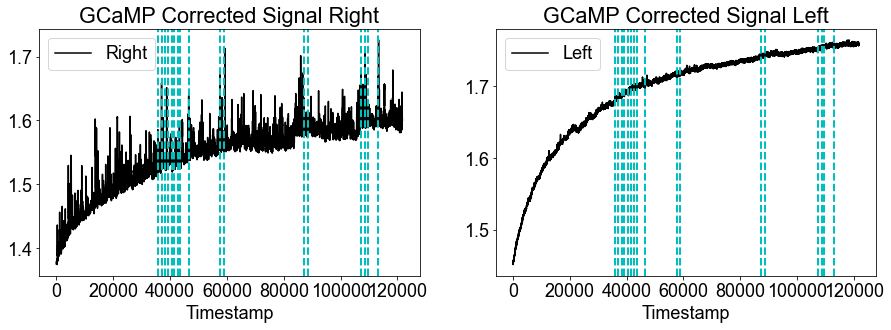

In [38]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(221)
ax1.plot(gcamp_corrected_signalright,'black',linewidth=1.5,label='Right')
ax1.set_xlabel('Timestamp')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.title('GCaMP Corrected Signal Right')
plt.legend()

ax2 = fig.add_subplot(222)
ax2.plot(gcamp_corrected_signalleft,'black',linewidth=1.5,label='Left')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
ax2.set_xlabel('Timestamp')
plt.title('GCaMP Corrected Signal Left')
plt.legend()

# Plot Corrected Data for 560/410

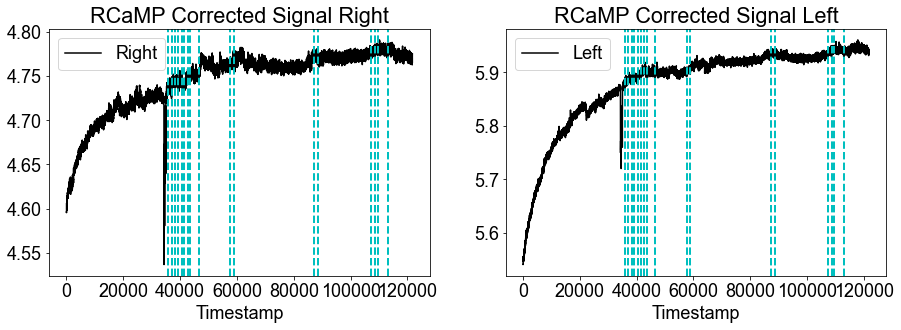

In [39]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(221)
ax1.plot(rcamp_corrected_signalright,'black',linewidth=1.5,label='Right')
ax1.set_xlabel('Timestamp')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.title('RCaMP Corrected Signal Right')
plt.legend()

ax2 = fig.add_subplot(222)
ax2.plot(rcamp_corrected_signalleft,'black',linewidth=1.5,label='Left')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
ax2.set_xlabel('Timestamp')
plt.title('RCaMP Corrected Signal Left')
plt.legend()

# Fit Corrected signals using Biexponential Function

In [40]:
#Define x and y for curvefits
x =  fprawdata410_df['Timestamp'].values
y1 = gcamp_corrected_signalright_df.values
y2 = gcamp_corrected_signalleft_df.values
y3 = rcamp_corrected_signalright_df.values
y4 = rcamp_corrected_signalleft_df.values

In [41]:
x

array([14431.964928, 14432.039872, 14432.11488 , ..., 23563.278688,
       23563.353664, 23563.428672])

In [42]:
y1

array([1.37572166, 1.37572166, 1.3757459 , ..., 1.60023386, 1.60031651,
       1.60042169])

In [43]:
y2

array([1.45182813, 1.45182813, 1.45180352, ..., 1.75973825, 1.75993506,
       1.75986068])

In [44]:
y4

array([5.54049318, 5.54049318, 5.54042495, ..., 5.94237553, 5.94181862,
       5.94091714])

[ 1.75110313e+00 -2.07515643e+03 -9.26269836e-07  1.69847387e+05]


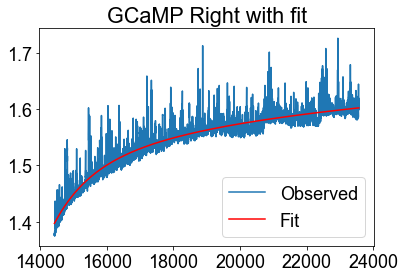

In [45]:
#for glp_corrected_signalright
def func(x, a, b, c, d):
    return a * np.exp(b / x) + c * np.exp(d / x)

#Define starting values for curve fit parameters

p0 = [ 1.75110314e+00 ,-2.07515660e+03 ,-9.26268775e-07 , 1.69847403e+05] #You are defining the initial guess values for the fit. This actually very important and 
#will need to be tweaked for each fit.

poptgcamp_right, pcov = scipy.optimize.curve_fit(func,x,y1,p0, maxfev=7500) 

#popt = optimal curve 
#pcov = The estimated covariance of popt
#cha
print(poptgcamp_right)
plt.plot(x,y1,label = 'Observed')
plt.plot(x,func(x,*poptgcamp_right),'red', label='Fit')
plt.title('GCaMP Right with fit')
plt.legend()

Text(0.5, 1.0, 'GCaMP Right Residual Error')

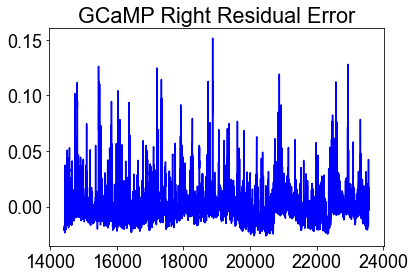

In [46]:
residualerror_gcampright = y1 - func(x, *poptgcamp_right)
plt.plot(x, residualerror_gcampright,'blue')
plt.title('GCaMP Right Residual Error')

[ 1.91926126e+00 -2.00812436e+03 -2.62946294e-07  1.95666856e+05]


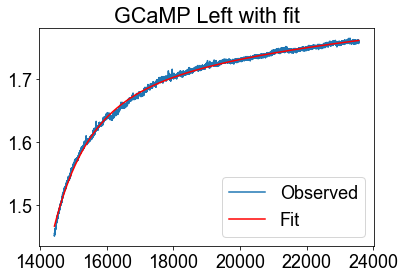

In [47]:
#for glp_corrected_signalleft
def func(x, a, b, c, d):
    return a * np.exp(b / x) + c * np.exp(d / x)

#Define starting values for curve fit parameters

p0 = [1.91926121e+00,-2.00812372e+03, -2.62947257e-07,  1.95666805e+05] #You are defining the initial guess values for the fit. This actually very important and 
#will need to be tweaked for each fit.

poptgcamp_left, pcov = scipy.optimize.curve_fit(func,x,y2,p0, maxfev=5000) 

#popt = optimal curve 
#pcov = The estimated covariance of popt
#cha
print(poptgcamp_left)
plt.plot(x,y2,label='Observed')
plt.plot(x,func(x,*poptgcamp_left),'red', label="Fit")
plt.title('GCaMP Left with fit')
plt.legend()

Text(0.5, 1.0, 'GLP Left Residual Error')

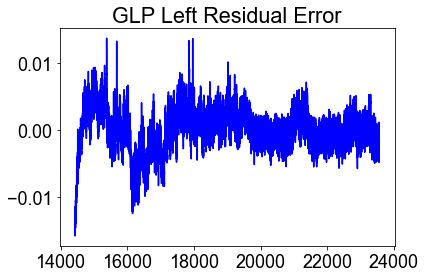

In [48]:
residualerror_gcampleft = y2 - func(x, *poptgcamp_left)
plt.plot(x, residualerror_gcampleft,'blue')
plt.title('GLP Left Residual Error')

[-7.78696031e-08  2.04774418e+05  4.84684093e+00 -3.35829086e+02]


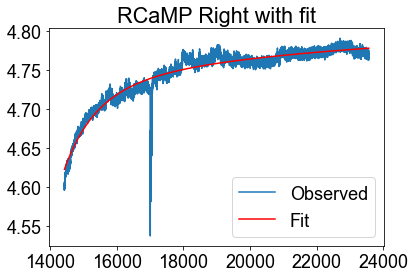

In [49]:
#for glp_corrected_signalright_red
def func(x, a, b, c, d):
    return a * np.exp(b / x) + c * np.exp(d / x)

#Define starting values for curve fit parameters

p0 = [-7.78914037e-08,  2.04770457e+05,  4.84683897e+00, -3.35819958e+02] #You are defining the initial guess values for the fit. This actually very important and 
#will need to be tweaked for each fit.

poptrcamp_right, pcov = scipy.optimize.curve_fit(func,x,y3,p0, maxfev=7500) 

#popt = optimal curve 
#pcov = The estimated covariance of popt
#cha
print(poptrcamp_right)
plt.plot(x,y3,label='Observed')
plt.plot(x,func(x,*poptrcamp_right),'red', label="Fit")
plt.title('RCaMP Right with fit')
plt.legend()

Text(0.5, 1.0, 'RCaMP Right Residual Error')

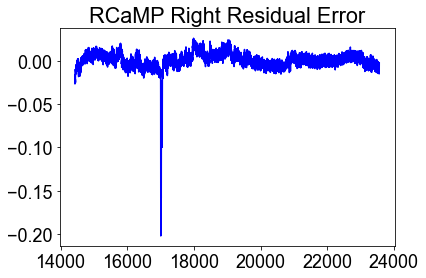

In [50]:
residualerror_rcampright = y3 - func(x, *poptrcamp_right)
plt.plot(x, residualerror_rcampright,'blue')
plt.title('RCaMP Right Residual Error')

[ 6.08206540e+00 -5.40468345e+02 -4.76974690e-09  2.58710490e+05]


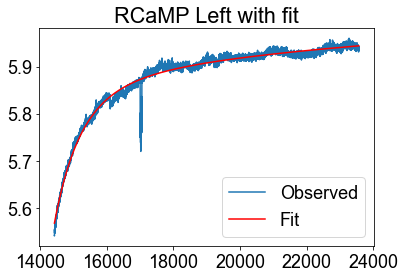

In [51]:
#for glp_corrected_signalleft_red
def func(x, a, b, c, d):
    return a * np.exp(b / x) + c * np.exp(d / x)

#Define starting values for curve fit parameters

p0 = [6.08206530e+00, -5.40467993e+02, -4.76978560e-09,  2.58710374e+05] #You are defining the initial guess values for the fit. This actually very important and 
#will need to be tweaked for each fit.

poptrcamp_left, pcov = scipy.optimize.curve_fit(func,x,y4,p0, maxfev=5000) 

#popt = optimal curve 
#pcov = The estimated covariance of popt
#cha
print(poptrcamp_left)
plt.plot(x,y4,label='Observed')
plt.plot(x,func(x,*poptrcamp_left),'red', label="Fit")
plt.title('RCaMP Left with fit')
plt.legend()

Text(0.5, 1.0, 'RCaMP Left Residual Error')

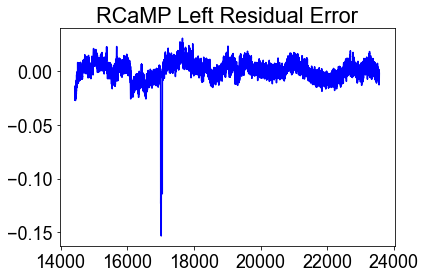

In [52]:
residualerror_rcampleft = y4 - func(x, *poptrcamp_left)
plt.plot(x, residualerror_rcampleft,'blue')
plt.title('RCaMP Left Residual Error')

# Subtract the fits from each corrected signal

In [53]:
#Definefits
gcampright_fit = func(x, *poptgcamp_right)
gcampleft_fit = func(x, *poptgcamp_left)
rcampright_fit = func(x, *poptrcamp_right)
rcampleft_fit = func(x, *poptrcamp_left)

In [54]:
#Subtractfits
gcampright_fitsub = gcamp_corrected_signalright_df/gcampright_fit
gcampleft_fitsub = gcamp_corrected_signalleft_df/gcampleft_fit

rcampright_fitsub = rcamp_corrected_signalright_df/rcampright_fit
rcampleft_fitsub = rcamp_corrected_signalleft_df/rcampleft_fit

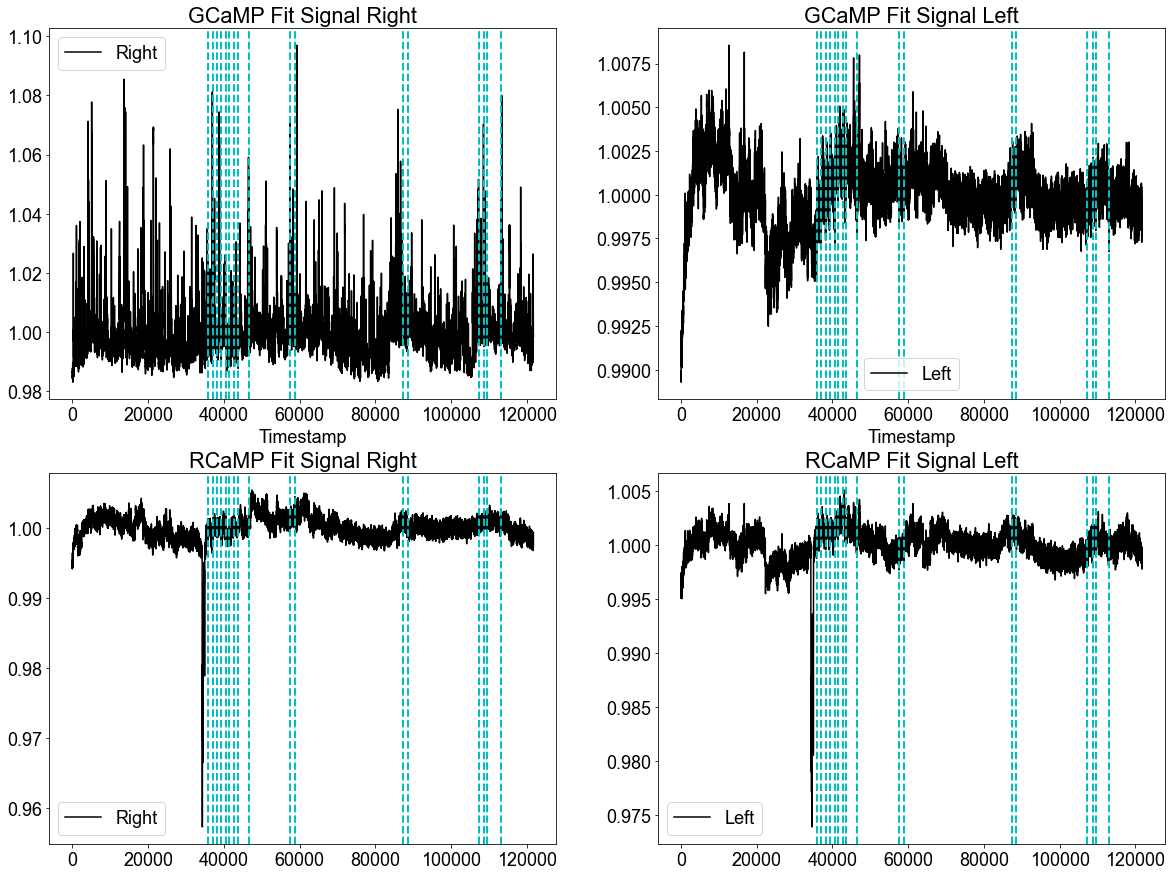

In [55]:
#Plot fit subtracted data 
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax1.plot(gcampright_fitsub,'black',linewidth=1.5,label='Right')
ax1.set_xlabel('Timestamp')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.title('GCaMP Fit Signal Right')
plt.legend()

ax2 = fig.add_subplot(222)
ax2.plot(gcampleft_fitsub,'black',linewidth=1.5,label='Left')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
ax2.set_xlabel('Timestamp')
plt.title('GCaMP Fit Signal Left')
plt.legend()

ax3 = fig.add_subplot(223)
ax3.plot(rcampright_fitsub,'black',linewidth=1.5,label='Right')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
ax2.set_xlabel('Timestamp')
plt.title('RCaMP Fit Signal Right')
plt.legend()

ax4 = fig.add_subplot(224)
ax4.plot(rcampleft_fitsub,'black',linewidth=1.5,label='Left')
plt.axvline(pellet1,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet2,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet3,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet4,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet5,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet6,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet7,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet8,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet9,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet10,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet11,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet12,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet13,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet14,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet15,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet16,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.axvline(pellet17,0,1,linewidth=2,color='c',linestyle='--') #Reference keydown to find spot to place line
ax2.set_xlabel('Timestamp')
plt.title('RCaMP Fit Signal Left')
plt.legend()

# Chop up data points

In [56]:
start1 = pellet1-600
stop1 = pellet1+600
start2 = pellet2-600
stop2 = pellet2+600
start3 = pellet3-600
stop3 = pellet3+600
start4 = pellet4-600
stop4 = pellet4+600
start5 = pellet5-600
stop5 = pellet5+600
start6 = pellet6-600
stop6 = pellet6+600
start7 = pellet7-600
stop7 = pellet7+600
start8 = pellet8-600
stop8 = pellet8+600
start9 = pellet9-600
stop9 = pellet9+600
start10 = pellet10-600
stop10 = pellet10+600
start11 = pellet11-600
stop11 = pellet11+600
start12 = pellet12-600
stop12 = pellet12+600
start13 = pellet13-600
stop13 = pellet13+600
start14 = pellet14-600
stop14 = pellet14+600
start15 = pellet15-600
stop15 = pellet15+600
start16 = pellet16-600
stop16 = pellet16+600
start17 = pellet17-600
stop17 = pellet17+600

In [57]:
#Define data ranges for each signal and reset indices for all of them
#GLPright470
gcamp_signalright_epoch1 = gcampright_fitsub[start1:stop1].reset_index()
gcamp_signalright_epoch2 = gcampright_fitsub[start2:stop2].reset_index()
gcamp_signalright_epoch3 = gcampright_fitsub[start3:stop3].reset_index()
gcamp_signalright_epoch4 = gcampright_fitsub[start4:stop4].reset_index()
gcamp_signalright_epoch5 = gcampright_fitsub[start5:stop5].reset_index()
gcamp_signalright_epoch6 = gcampright_fitsub[start6:stop6].reset_index()
gcamp_signalright_epoch7 = gcampright_fitsub[start7:stop7].reset_index()
gcamp_signalright_epoch8 = gcampright_fitsub[start8:stop8].reset_index()
gcamp_signalright_epoch9 = gcampright_fitsub[start9:stop9].reset_index()
gcamp_signalright_epoch10 = gcampright_fitsub[start10:stop10].reset_index()
gcamp_signalright_epoch11 = gcampright_fitsub[start11:stop11].reset_index()
gcamp_signalright_epoch12 = gcampright_fitsub[start12:stop12].reset_index()
gcamp_signalright_epoch13 = gcampright_fitsub[start13:stop13].reset_index()
gcamp_signalright_epoch14 = gcampright_fitsub[start14:stop14].reset_index()
gcamp_signalright_epoch15 = gcampright_fitsub[start15:stop15].reset_index()
gcamp_signalright_epoch16 = gcampright_fitsub[start16:stop16].reset_index()
gcamp_signalright_epoch17 = gcampright_fitsub[start17:stop17].reset_index()

#GLPleft470
gcamp_signalleft_epoch1 = gcampleft_fitsub[start1:stop1].reset_index()
gcamp_signalleft_epoch2 = gcampleft_fitsub[start2:stop2].reset_index()
gcamp_signalleft_epoch3 = gcampleft_fitsub[start3:stop3].reset_index()
gcamp_signalleft_epoch4 = gcampleft_fitsub[start4:stop4].reset_index()
gcamp_signalleft_epoch5 = gcampleft_fitsub[start5:stop5].reset_index()
gcamp_signalleft_epoch6 = gcampleft_fitsub[start6:stop6].reset_index()
gcamp_signalleft_epoch7 = gcampleft_fitsub[start7:stop7].reset_index()
gcamp_signalleft_epoch8 = gcampleft_fitsub[start8:stop8].reset_index()
gcamp_signalleft_epoch9 = gcampleft_fitsub[start9:stop9].reset_index()
gcamp_signalleft_epoch10 = gcampleft_fitsub[start10:stop10].reset_index()
gcamp_signalleft_epoch11 = gcampleft_fitsub[start11:stop11].reset_index()
gcamp_signalleft_epoch12 = gcampleft_fitsub[start12:stop12].reset_index()
gcamp_signalleft_epoch13 = gcampleft_fitsub[start13:stop13].reset_index()
gcamp_signalleft_epoch14 = gcampleft_fitsub[start14:stop14].reset_index()
gcamp_signalleft_epoch15 = gcampleft_fitsub[start15:stop15].reset_index()
gcamp_signalleft_epoch16 = gcampleft_fitsub[start16:stop16].reset_index()
gcamp_signalleft_epoch17 = gcampleft_fitsub[start17:stop17].reset_index()

#GLPright560
rcamp_signalright_epoch1 = rcampright_fitsub[start1:stop1].reset_index()
rcamp_signalright_epoch2 = rcampright_fitsub[start2:stop2].reset_index()
rcamp_signalright_epoch3 = rcampright_fitsub[start3:stop3].reset_index()
rcamp_signalright_epoch4 = rcampright_fitsub[start4:stop4].reset_index()
rcamp_signalright_epoch5 = rcampright_fitsub[start5:stop5].reset_index()
rcamp_signalright_epoch6 = rcampright_fitsub[start6:stop6].reset_index()
rcamp_signalright_epoch7 = rcampright_fitsub[start7:stop7].reset_index()
rcamp_signalright_epoch8 = rcampright_fitsub[start8:stop8].reset_index()
rcamp_signalright_epoch9 = rcampright_fitsub[start9:stop9].reset_index()
rcamp_signalright_epoch10 = rcampright_fitsub[start10:stop10].reset_index()
rcamp_signalright_epoch11 = rcampright_fitsub[start11:stop11].reset_index()
rcamp_signalright_epoch12 = rcampright_fitsub[start12:stop12].reset_index()
rcamp_signalright_epoch13 = rcampright_fitsub[start13:stop13].reset_index()
rcamp_signalright_epoch14 = rcampright_fitsub[start14:stop14].reset_index()
rcamp_signalright_epoch15 = rcampright_fitsub[start15:stop15].reset_index()
rcamp_signalright_epoch16 = rcampright_fitsub[start16:stop16].reset_index()
rcamp_signalright_epoch17 = rcampright_fitsub[start17:stop17].reset_index()

#GLPleft560
rcamp_signalleft_epoch1 = rcampleft_fitsub[start1:stop1].reset_index()
rcamp_signalleft_epoch2 = rcampleft_fitsub[start2:stop2].reset_index()
rcamp_signalleft_epoch3 = rcampleft_fitsub[start3:stop3].reset_index()
rcamp_signalleft_epoch4 = rcampleft_fitsub[start4:stop4].reset_index()
rcamp_signalleft_epoch5 = rcampleft_fitsub[start5:stop5].reset_index()
rcamp_signalleft_epoch6 = rcampleft_fitsub[start6:stop6].reset_index()
rcamp_signalleft_epoch7 = rcampleft_fitsub[start7:stop7].reset_index()
rcamp_signalleft_epoch8 = rcampleft_fitsub[start8:stop8].reset_index()
rcamp_signalleft_epoch9 = rcampleft_fitsub[start9:stop9].reset_index()
rcamp_signalleft_epoch10 = rcampleft_fitsub[start10:stop10].reset_index()
rcamp_signalleft_epoch11 = rcampleft_fitsub[start11:stop11].reset_index()
rcamp_signalleft_epoch12 = rcampleft_fitsub[start12:stop12].reset_index()
rcamp_signalleft_epoch13 = rcampleft_fitsub[start13:stop13].reset_index()
rcamp_signalleft_epoch14 = rcampleft_fitsub[start14:stop14].reset_index()
rcamp_signalleft_epoch15 = rcampleft_fitsub[start15:stop15].reset_index()
rcamp_signalleft_epoch16 = rcampleft_fitsub[start16:stop16].reset_index()
rcamp_signalleft_epoch17 = rcampleft_fitsub[start17:stop17].reset_index()

In [58]:
gcamp_signalright_epoch1.drop('index',1, inplace=True)
gcamp_signalright_epoch2.drop('index',1, inplace=True)
gcamp_signalright_epoch3.drop('index',1, inplace=True)
gcamp_signalright_epoch4.drop('index',1, inplace=True)
gcamp_signalright_epoch5.drop('index',1, inplace=True)
gcamp_signalright_epoch6.drop('index',1, inplace=True)
gcamp_signalright_epoch7.drop('index',1, inplace=True)
gcamp_signalright_epoch8.drop('index',1, inplace=True)
gcamp_signalright_epoch9.drop('index',1, inplace=True)
gcamp_signalright_epoch10.drop('index',1, inplace=True)
gcamp_signalright_epoch11.drop('index',1, inplace=True)
gcamp_signalright_epoch12.drop('index',1, inplace=True)
gcamp_signalright_epoch13.drop('index',1, inplace=True)
gcamp_signalright_epoch14.drop('index',1, inplace=True)
gcamp_signalright_epoch15.drop('index',1, inplace=True)
gcamp_signalright_epoch16.drop('index',1, inplace=True)
gcamp_signalright_epoch17.drop('index',1, inplace=True)


gcamp_signalleft_epoch1.drop('index',1, inplace=True)
gcamp_signalleft_epoch2.drop('index',1, inplace=True)
gcamp_signalleft_epoch3.drop('index',1, inplace=True)
gcamp_signalleft_epoch4.drop('index',1, inplace=True)
gcamp_signalleft_epoch5.drop('index',1, inplace=True)
gcamp_signalleft_epoch6.drop('index',1, inplace=True)
gcamp_signalleft_epoch7.drop('index',1, inplace=True)
gcamp_signalleft_epoch8.drop('index',1, inplace=True)
gcamp_signalleft_epoch9.drop('index',1, inplace=True)
gcamp_signalleft_epoch10.drop('index',1, inplace=True)
gcamp_signalleft_epoch11.drop('index',1, inplace=True)
gcamp_signalleft_epoch12.drop('index',1, inplace=True)
gcamp_signalleft_epoch13.drop('index',1, inplace=True)
gcamp_signalleft_epoch14.drop('index',1, inplace=True)
gcamp_signalleft_epoch15.drop('index',1, inplace=True)
gcamp_signalleft_epoch16.drop('index',1, inplace=True)
gcamp_signalleft_epoch17.drop('index',1, inplace=True)


rcamp_signalright_epoch1.drop('index',1, inplace=True)
rcamp_signalright_epoch2.drop('index',1, inplace=True)
rcamp_signalright_epoch3.drop('index',1, inplace=True)
rcamp_signalright_epoch4.drop('index',1, inplace=True)
rcamp_signalright_epoch5.drop('index',1, inplace=True)
rcamp_signalright_epoch6.drop('index',1, inplace=True)
rcamp_signalright_epoch7.drop('index',1, inplace=True)
rcamp_signalright_epoch8.drop('index',1, inplace=True)
rcamp_signalright_epoch9.drop('index',1, inplace=True)
rcamp_signalright_epoch10.drop('index',1, inplace=True)
rcamp_signalright_epoch11.drop('index',1, inplace=True)
rcamp_signalright_epoch12.drop('index',1, inplace=True)
rcamp_signalright_epoch13.drop('index',1, inplace=True)
rcamp_signalright_epoch14.drop('index',1, inplace=True)
rcamp_signalright_epoch15.drop('index',1, inplace=True)
rcamp_signalright_epoch16.drop('index',1, inplace=True)
rcamp_signalright_epoch17.drop('index',1, inplace=True)


rcamp_signalleft_epoch1.drop('index',1, inplace=True)
rcamp_signalleft_epoch2.drop('index',1, inplace=True)
rcamp_signalleft_epoch3.drop('index',1, inplace=True)
rcamp_signalleft_epoch4.drop('index',1, inplace=True)
rcamp_signalleft_epoch5.drop('index',1, inplace=True)
rcamp_signalleft_epoch6.drop('index',1, inplace=True)
rcamp_signalleft_epoch7.drop('index',1, inplace=True)
rcamp_signalleft_epoch8.drop('index',1, inplace=True)
rcamp_signalleft_epoch9.drop('index',1, inplace=True)
rcamp_signalleft_epoch10.drop('index',1, inplace=True)
rcamp_signalleft_epoch11.drop('index',1, inplace=True)
rcamp_signalleft_epoch12.drop('index',1, inplace=True)
rcamp_signalleft_epoch13.drop('index',1, inplace=True)
rcamp_signalleft_epoch14.drop('index',1, inplace=True)
rcamp_signalleft_epoch15.drop('index',1, inplace=True)
rcamp_signalleft_epoch16.drop('index',1, inplace=True)
rcamp_signalleft_epoch17.drop('index',1, inplace=True)

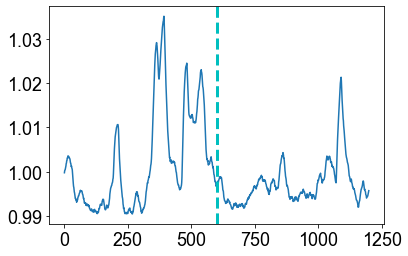

In [68]:
plt.plot(gcamp_signalright_epoch1)
plt.axvline(600,0,1,linewidth=3,color='c',linestyle='--') #Reference keydown to find spot to place line

# Calculate the baseline average and df/f for each period

In [60]:
#Calculates the average F for each baseline period prior to pellet consumption
#Since some of these values are negative this winds up giving you pretty screwy values. Will need to Z-score

#GLPright470
gcamp_signalright_epoch1_averageF = gcamp_signalright_epoch1.iloc[0:600].mean()
gcamp_signalright_epoch2_averageF = gcamp_signalright_epoch2.iloc[0:600].mean()
gcamp_signalright_epoch3_averageF = gcamp_signalright_epoch3.iloc[0:600].mean()
gcamp_signalright_epoch4_averageF = gcamp_signalright_epoch4.iloc[0:600].mean()
gcamp_signalright_epoch5_averageF = gcamp_signalright_epoch5.iloc[0:600].mean()
gcamp_signalright_epoch6_averageF = gcamp_signalright_epoch6.iloc[0:600].mean()
gcamp_signalright_epoch7_averageF = gcamp_signalright_epoch7.iloc[0:600].mean()
gcamp_signalright_epoch8_averageF = gcamp_signalright_epoch8.iloc[0:600].mean()
gcamp_signalright_epoch9_averageF = gcamp_signalright_epoch9.iloc[0:600].mean()
gcamp_signalright_epoch10_averageF = gcamp_signalright_epoch10.iloc[0:600].mean()
gcamp_signalright_epoch1_STD = gcamp_signalright_epoch1.iloc[0:600].std()
gcamp_signalright_epoch2_STD = gcamp_signalright_epoch2.iloc[0:600].std()
gcamp_signalright_epoch3_STD = gcamp_signalright_epoch3.iloc[0:600].std()
gcamp_signalright_epoch4_STD = gcamp_signalright_epoch4.iloc[0:600].std()
gcamp_signalright_epoch5_STD = gcamp_signalright_epoch5.iloc[0:600].std()
gcamp_signalright_epoch6_STD = gcamp_signalright_epoch6.iloc[0:600].std()
gcamp_signalright_epoch7_STD = gcamp_signalright_epoch7.iloc[0:600].std()
gcamp_signalright_epoch8_STD = gcamp_signalright_epoch8.iloc[0:600].std()
gcamp_signalright_epoch9_STD = gcamp_signalright_epoch9.iloc[0:600].std()
gcamp_signalright_epoch10_STD = gcamp_signalright_epoch10.iloc[0:600].std()

gcamp_signalright_epoch11_averageF = gcamp_signalright_epoch11.iloc[0:600].mean()
gcamp_signalright_epoch12_averageF = gcamp_signalright_epoch12.iloc[0:600].mean()
gcamp_signalright_epoch13_averageF = gcamp_signalright_epoch13.iloc[0:600].mean()
gcamp_signalright_epoch14_averageF = gcamp_signalright_epoch14.iloc[0:600].mean()
gcamp_signalright_epoch15_averageF = gcamp_signalright_epoch15.iloc[0:600].mean()
gcamp_signalright_epoch16_averageF = gcamp_signalright_epoch16.iloc[0:600].mean()
gcamp_signalright_epoch17_averageF = gcamp_signalright_epoch17.iloc[0:600].mean()
gcamp_signalright_epoch11_STD = gcamp_signalright_epoch11.iloc[0:600].std()
gcamp_signalright_epoch12_STD = gcamp_signalright_epoch12.iloc[0:600].std()
gcamp_signalright_epoch13_STD = gcamp_signalright_epoch13.iloc[0:600].std()
gcamp_signalright_epoch14_STD = gcamp_signalright_epoch14.iloc[0:600].std()
gcamp_signalright_epoch15_STD = gcamp_signalright_epoch15.iloc[0:600].std()
gcamp_signalright_epoch16_STD = gcamp_signalright_epoch16.iloc[0:600].std()
gcamp_signalright_epoch17_STD = gcamp_signalright_epoch17.iloc[0:600].std()


#GLPleft470
gcamp_signalleft_epoch1_averageF = gcamp_signalleft_epoch1.iloc[0:600].mean()
gcamp_signalleft_epoch2_averageF = gcamp_signalleft_epoch2.iloc[0:600].mean()
gcamp_signalleft_epoch3_averageF = gcamp_signalleft_epoch3.iloc[0:600].mean()
gcamp_signalleft_epoch4_averageF = gcamp_signalleft_epoch4.iloc[0:600].mean()
gcamp_signalleft_epoch5_averageF = gcamp_signalleft_epoch5.iloc[0:600].mean()
gcamp_signalleft_epoch6_averageF = gcamp_signalleft_epoch6.iloc[0:600].mean()
gcamp_signalleft_epoch7_averageF = gcamp_signalleft_epoch7.iloc[0:600].mean()
gcamp_signalleft_epoch8_averageF = gcamp_signalleft_epoch8.iloc[0:600].mean()
gcamp_signalleft_epoch9_averageF = gcamp_signalleft_epoch9.iloc[0:600].mean()
gcamp_signalleft_epoch10_averageF = gcamp_signalleft_epoch10.iloc[0:600].mean()
gcamp_signalleft_epoch1_STD = gcamp_signalleft_epoch1.iloc[0:600].std()
gcamp_signalleft_epoch2_STD = gcamp_signalleft_epoch2.iloc[0:600].std()
gcamp_signalleft_epoch3_STD = gcamp_signalleft_epoch3.iloc[0:600].std()
gcamp_signalleft_epoch4_STD = gcamp_signalleft_epoch4.iloc[0:600].std()
gcamp_signalleft_epoch5_STD = gcamp_signalleft_epoch5.iloc[0:600].std()
gcamp_signalleft_epoch6_STD = gcamp_signalleft_epoch6.iloc[0:600].std()
gcamp_signalleft_epoch7_STD = gcamp_signalleft_epoch7.iloc[0:600].std()
gcamp_signalleft_epoch8_STD = gcamp_signalleft_epoch8.iloc[0:600].std()
gcamp_signalleft_epoch9_STD = gcamp_signalleft_epoch9.iloc[0:600].std()
gcamp_signalleft_epoch10_STD = gcamp_signalleft_epoch10.iloc[0:600].std()

gcamp_signalleft_epoch11_averageF = gcamp_signalleft_epoch11.iloc[0:600].mean()
gcamp_signalleft_epoch12_averageF = gcamp_signalleft_epoch12.iloc[0:600].mean()
gcamp_signalleft_epoch13_averageF = gcamp_signalleft_epoch13.iloc[0:600].mean()
gcamp_signalleft_epoch14_averageF = gcamp_signalleft_epoch14.iloc[0:600].mean()
gcamp_signalleft_epoch15_averageF = gcamp_signalleft_epoch15.iloc[0:600].mean()
gcamp_signalleft_epoch16_averageF = gcamp_signalleft_epoch16.iloc[0:600].mean()
gcamp_signalleft_epoch17_averageF = gcamp_signalleft_epoch17.iloc[0:600].mean()
gcamp_signalleft_epoch11_STD = gcamp_signalleft_epoch11.iloc[0:600].std()
gcamp_signalleft_epoch12_STD = gcamp_signalleft_epoch12.iloc[0:600].std()
gcamp_signalleft_epoch13_STD = gcamp_signalleft_epoch13.iloc[0:600].std()
gcamp_signalleft_epoch14_STD = gcamp_signalleft_epoch14.iloc[0:600].std()
gcamp_signalleft_epoch15_STD = gcamp_signalleft_epoch15.iloc[0:600].std()
gcamp_signalleft_epoch16_STD = gcamp_signalleft_epoch16.iloc[0:600].std()
gcamp_signalleft_epoch17_STD = gcamp_signalleft_epoch17.iloc[0:600].std()


#GLPright560
rcamp_signalright_epoch1_averageF = rcamp_signalright_epoch1.iloc[0:600].mean()
rcamp_signalright_epoch2_averageF = rcamp_signalright_epoch2.iloc[0:600].mean()
rcamp_signalright_epoch3_averageF = rcamp_signalright_epoch3.iloc[0:600].mean()
rcamp_signalright_epoch4_averageF = rcamp_signalright_epoch4.iloc[0:600].mean()
rcamp_signalright_epoch5_averageF = rcamp_signalright_epoch5.iloc[0:600].mean()
rcamp_signalright_epoch6_averageF = rcamp_signalright_epoch6.iloc[0:600].mean()
rcamp_signalright_epoch7_averageF = rcamp_signalright_epoch7.iloc[0:600].mean()
rcamp_signalright_epoch8_averageF = rcamp_signalright_epoch8.iloc[0:600].mean()
rcamp_signalright_epoch9_averageF = rcamp_signalright_epoch9.iloc[0:600].mean()
rcamp_signalright_epoch10_averageF = rcamp_signalright_epoch10.iloc[0:600].mean()
rcamp_signalright_epoch1_STD = rcamp_signalright_epoch1.iloc[0:600].std()
rcamp_signalright_epoch2_STD = rcamp_signalright_epoch2.iloc[0:600].std()
rcamp_signalright_epoch3_STD = rcamp_signalright_epoch3.iloc[0:600].std()
rcamp_signalright_epoch4_STD = rcamp_signalright_epoch4.iloc[0:600].std()
rcamp_signalright_epoch5_STD = rcamp_signalright_epoch5.iloc[0:600].std()
rcamp_signalright_epoch6_STD = rcamp_signalright_epoch6.iloc[0:600].std()
rcamp_signalright_epoch7_STD = rcamp_signalright_epoch7.iloc[0:600].std()
rcamp_signalright_epoch8_STD = rcamp_signalright_epoch8.iloc[0:600].std()
rcamp_signalright_epoch9_STD = rcamp_signalright_epoch9.iloc[0:600].std()
rcamp_signalright_epoch10_STD = rcamp_signalright_epoch10.iloc[0:600].std()

rcamp_signalright_epoch11_averageF = rcamp_signalright_epoch11.iloc[0:600].mean()
rcamp_signalright_epoch12_averageF = rcamp_signalright_epoch12.iloc[0:600].mean()
rcamp_signalright_epoch13_averageF = rcamp_signalright_epoch13.iloc[0:600].mean()
rcamp_signalright_epoch14_averageF = rcamp_signalright_epoch14.iloc[0:600].mean()
rcamp_signalright_epoch15_averageF = rcamp_signalright_epoch15.iloc[0:600].mean()
rcamp_signalright_epoch16_averageF = rcamp_signalright_epoch16.iloc[0:600].mean()
rcamp_signalright_epoch17_averageF = rcamp_signalright_epoch17.iloc[0:600].mean()
rcamp_signalright_epoch11_STD = rcamp_signalright_epoch11.iloc[0:600].std()
rcamp_signalright_epoch12_STD = rcamp_signalright_epoch12.iloc[0:600].std()
rcamp_signalright_epoch13_STD = rcamp_signalright_epoch13.iloc[0:600].std()
rcamp_signalright_epoch14_STD = rcamp_signalright_epoch14.iloc[0:600].std()
rcamp_signalright_epoch15_STD = rcamp_signalright_epoch15.iloc[0:600].std()
rcamp_signalright_epoch16_STD = rcamp_signalright_epoch16.iloc[0:600].std()
rcamp_signalright_epoch17_STD = rcamp_signalright_epoch17.iloc[0:600].std()



#GLPleft560
rcamp_signalleft_epoch1_averageF = rcamp_signalleft_epoch1.iloc[0:600].mean()
rcamp_signalleft_epoch2_averageF = rcamp_signalleft_epoch2.iloc[0:600].mean()
rcamp_signalleft_epoch3_averageF = rcamp_signalleft_epoch3.iloc[0:600].mean()
rcamp_signalleft_epoch4_averageF = rcamp_signalleft_epoch4.iloc[0:600].mean()
rcamp_signalleft_epoch5_averageF = rcamp_signalleft_epoch5.iloc[0:600].mean()
rcamp_signalleft_epoch6_averageF = rcamp_signalleft_epoch6.iloc[0:600].mean()
rcamp_signalleft_epoch7_averageF = rcamp_signalleft_epoch7.iloc[0:600].mean()
rcamp_signalleft_epoch8_averageF = rcamp_signalleft_epoch8.iloc[0:600].mean()
rcamp_signalleft_epoch9_averageF = rcamp_signalleft_epoch9.iloc[0:600].mean()
rcamp_signalleft_epoch10_averageF = rcamp_signalleft_epoch10.iloc[0:600].mean()
rcamp_signalleft_epoch1_STD = rcamp_signalleft_epoch1.iloc[0:600].std()
rcamp_signalleft_epoch2_STD = rcamp_signalleft_epoch2.iloc[0:600].std()
rcamp_signalleft_epoch3_STD = rcamp_signalleft_epoch3.iloc[0:600].std()
rcamp_signalleft_epoch4_STD = rcamp_signalleft_epoch4.iloc[0:600].std()
rcamp_signalleft_epoch5_STD = rcamp_signalleft_epoch5.iloc[0:600].std()
rcamp_signalleft_epoch6_STD = rcamp_signalleft_epoch6.iloc[0:600].std()
rcamp_signalleft_epoch7_STD = rcamp_signalleft_epoch7.iloc[0:600].std()
rcamp_signalleft_epoch8_STD = rcamp_signalleft_epoch8.iloc[0:600].std()
rcamp_signalleft_epoch9_STD = rcamp_signalleft_epoch9.iloc[0:600].std()
rcamp_signalleft_epoch10_STD = rcamp_signalleft_epoch10.iloc[0:600].std()

rcamp_signalleft_epoch11_averageF = rcamp_signalleft_epoch11.iloc[0:600].mean()
rcamp_signalleft_epoch12_averageF = rcamp_signalleft_epoch12.iloc[0:600].mean()
rcamp_signalleft_epoch13_averageF = rcamp_signalleft_epoch13.iloc[0:600].mean()
rcamp_signalleft_epoch14_averageF = rcamp_signalleft_epoch14.iloc[0:600].mean()
rcamp_signalleft_epoch15_averageF = rcamp_signalleft_epoch15.iloc[0:600].mean()
rcamp_signalleft_epoch16_averageF = rcamp_signalleft_epoch16.iloc[0:600].mean()
rcamp_signalleft_epoch17_averageF = rcamp_signalleft_epoch17.iloc[0:600].mean()
rcamp_signalleft_epoch11_STD = rcamp_signalleft_epoch11.iloc[0:600].std()
rcamp_signalleft_epoch12_STD = rcamp_signalleft_epoch12.iloc[0:600].std()
rcamp_signalleft_epoch13_STD = rcamp_signalleft_epoch13.iloc[0:600].std()
rcamp_signalleft_epoch14_STD = rcamp_signalleft_epoch14.iloc[0:600].std()
rcamp_signalleft_epoch15_STD = rcamp_signalleft_epoch15.iloc[0:600].std()
rcamp_signalleft_epoch16_STD = rcamp_signalleft_epoch16.iloc[0:600].std()
rcamp_signalleft_epoch17_STD = rcamp_signalleft_epoch17.iloc[0:600].std()

# Calculate normalized signal for each time range

In [61]:
#this is the z score calculation
#GLPright470
gcamp_normalizedzsignalright_epoch1 = (gcamp_signalright_epoch1 - gcamp_signalright_epoch1_averageF)/gcamp_signalright_epoch1_STD
gcamp_normalizedzsignalright_epoch2 = (gcamp_signalright_epoch2 - gcamp_signalright_epoch2_averageF)/gcamp_signalright_epoch2_STD
gcamp_normalizedzsignalright_epoch3 = (gcamp_signalright_epoch3 - gcamp_signalright_epoch3_averageF)/gcamp_signalright_epoch3_STD
gcamp_normalizedzsignalright_epoch4 = (gcamp_signalright_epoch4 - gcamp_signalright_epoch4_averageF)/gcamp_signalright_epoch4_STD
gcamp_normalizedzsignalright_epoch5 = (gcamp_signalright_epoch5 - gcamp_signalright_epoch5_averageF)/gcamp_signalright_epoch5_STD
gcamp_normalizedzsignalright_epoch6 = (gcamp_signalright_epoch6 - gcamp_signalright_epoch6_averageF)/gcamp_signalright_epoch6_STD
gcamp_normalizedzsignalright_epoch7 = (gcamp_signalright_epoch7 - gcamp_signalright_epoch7_averageF)/gcamp_signalright_epoch7_STD
gcamp_normalizedzsignalright_epoch8 = (gcamp_signalright_epoch8 - gcamp_signalright_epoch8_averageF)/gcamp_signalright_epoch8_STD
gcamp_normalizedzsignalright_epoch9 = (gcamp_signalright_epoch9 - gcamp_signalright_epoch9_averageF)/gcamp_signalright_epoch9_STD
gcamp_normalizedzsignalright_epoch10 = (gcamp_signalright_epoch10 - gcamp_signalright_epoch10_averageF)/gcamp_signalright_epoch10_STD
gcamp_normalizedzsignalright_epoch11 = (gcamp_signalright_epoch11 - gcamp_signalright_epoch11_averageF)/gcamp_signalright_epoch11_STD
gcamp_normalizedzsignalright_epoch12 = (gcamp_signalright_epoch12 - gcamp_signalright_epoch12_averageF)/gcamp_signalright_epoch12_STD
gcamp_normalizedzsignalright_epoch13 = (gcamp_signalright_epoch13 - gcamp_signalright_epoch13_averageF)/gcamp_signalright_epoch13_STD
gcamp_normalizedzsignalright_epoch14 = (gcamp_signalright_epoch14 - gcamp_signalright_epoch14_averageF)/gcamp_signalright_epoch14_STD
gcamp_normalizedzsignalright_epoch15 = (gcamp_signalright_epoch15 - gcamp_signalright_epoch15_averageF)/gcamp_signalright_epoch15_STD
gcamp_normalizedzsignalright_epoch16 = (gcamp_signalright_epoch16 - gcamp_signalright_epoch16_averageF)/gcamp_signalright_epoch16_STD
gcamp_normalizedzsignalright_epoch17 = (gcamp_signalright_epoch17 - gcamp_signalright_epoch17_averageF)/gcamp_signalright_epoch17_STD


#GLPleft470
gcamp_normalizedzsignalleft_epoch1 = (gcamp_signalleft_epoch1 - gcamp_signalleft_epoch1_averageF)/gcamp_signalleft_epoch1_STD
gcamp_normalizedzsignalleft_epoch2 = (gcamp_signalleft_epoch2 - gcamp_signalleft_epoch2_averageF)/gcamp_signalleft_epoch2_STD
gcamp_normalizedzsignalleft_epoch3 = (gcamp_signalleft_epoch3 - gcamp_signalleft_epoch3_averageF)/gcamp_signalleft_epoch3_STD
gcamp_normalizedzsignalleft_epoch4 = (gcamp_signalleft_epoch4 - gcamp_signalleft_epoch4_averageF)/gcamp_signalleft_epoch4_STD
gcamp_normalizedzsignalleft_epoch5 = (gcamp_signalleft_epoch5 - gcamp_signalleft_epoch5_averageF)/gcamp_signalleft_epoch5_STD
gcamp_normalizedzsignalleft_epoch6 = (gcamp_signalleft_epoch6 - gcamp_signalleft_epoch6_averageF)/gcamp_signalleft_epoch6_STD
gcamp_normalizedzsignalleft_epoch7 = (gcamp_signalleft_epoch7 - gcamp_signalleft_epoch7_averageF)/gcamp_signalleft_epoch7_STD
gcamp_normalizedzsignalleft_epoch8 = (gcamp_signalleft_epoch8 - gcamp_signalleft_epoch8_averageF)/gcamp_signalleft_epoch8_STD
gcamp_normalizedzsignalleft_epoch9 = (gcamp_signalleft_epoch9 - gcamp_signalleft_epoch9_averageF)/gcamp_signalleft_epoch9_STD
gcamp_normalizedzsignalleft_epoch10 = (gcamp_signalleft_epoch10 - gcamp_signalleft_epoch10_averageF)/gcamp_signalleft_epoch10_STD
gcamp_normalizedzsignalleft_epoch11 = (gcamp_signalleft_epoch11 - gcamp_signalleft_epoch11_averageF)/gcamp_signalleft_epoch11_STD
gcamp_normalizedzsignalleft_epoch12 = (gcamp_signalleft_epoch12 - gcamp_signalleft_epoch12_averageF)/gcamp_signalleft_epoch12_STD
gcamp_normalizedzsignalleft_epoch13 = (gcamp_signalleft_epoch13 - gcamp_signalleft_epoch13_averageF)/gcamp_signalleft_epoch13_STD
gcamp_normalizedzsignalleft_epoch14 = (gcamp_signalleft_epoch14 - gcamp_signalleft_epoch14_averageF)/gcamp_signalleft_epoch14_STD
gcamp_normalizedzsignalleft_epoch15 = (gcamp_signalleft_epoch15 - gcamp_signalleft_epoch15_averageF)/gcamp_signalleft_epoch15_STD
gcamp_normalizedzsignalleft_epoch16 = (gcamp_signalleft_epoch16 - gcamp_signalleft_epoch16_averageF)/gcamp_signalleft_epoch16_STD
gcamp_normalizedzsignalleft_epoch17 = (gcamp_signalleft_epoch17 - gcamp_signalleft_epoch17_averageF)/gcamp_signalleft_epoch17_STD


#GLPright560
rcamp_normalizedzsignalright_epoch1 = (rcamp_signalright_epoch1 - rcamp_signalright_epoch1_averageF)/rcamp_signalright_epoch1_STD
rcamp_normalizedzsignalright_epoch2 = (rcamp_signalright_epoch2 - rcamp_signalright_epoch2_averageF)/rcamp_signalright_epoch2_STD
rcamp_normalizedzsignalright_epoch3 = (rcamp_signalright_epoch3 - rcamp_signalright_epoch3_averageF)/rcamp_signalright_epoch3_STD
rcamp_normalizedzsignalright_epoch4 = (rcamp_signalright_epoch4 - rcamp_signalright_epoch4_averageF)/rcamp_signalright_epoch4_STD
rcamp_normalizedzsignalright_epoch5 = (rcamp_signalright_epoch5 - rcamp_signalright_epoch5_averageF)/rcamp_signalright_epoch5_STD
rcamp_normalizedzsignalright_epoch6 = (rcamp_signalright_epoch6 - rcamp_signalright_epoch6_averageF)/rcamp_signalright_epoch6_STD
rcamp_normalizedzsignalright_epoch7 = (rcamp_signalright_epoch7 - rcamp_signalright_epoch7_averageF)/rcamp_signalright_epoch7_STD
rcamp_normalizedzsignalright_epoch8 = (rcamp_signalright_epoch8 - rcamp_signalright_epoch8_averageF)/rcamp_signalright_epoch8_STD
rcamp_normalizedzsignalright_epoch9 = (rcamp_signalright_epoch9 - rcamp_signalright_epoch9_averageF)/rcamp_signalright_epoch9_STD
rcamp_normalizedzsignalright_epoch10 = (rcamp_signalright_epoch10 - rcamp_signalright_epoch10_averageF)/rcamp_signalright_epoch10_STD
rcamp_normalizedzsignalright_epoch11 = (rcamp_signalright_epoch11 - rcamp_signalright_epoch11_averageF)/rcamp_signalright_epoch11_STD
rcamp_normalizedzsignalright_epoch12 = (rcamp_signalright_epoch12 - rcamp_signalright_epoch12_averageF)/rcamp_signalright_epoch12_STD
rcamp_normalizedzsignalright_epoch13 = (rcamp_signalright_epoch13 - rcamp_signalright_epoch13_averageF)/rcamp_signalright_epoch13_STD
rcamp_normalizedzsignalright_epoch14 = (rcamp_signalright_epoch14 - rcamp_signalright_epoch14_averageF)/rcamp_signalright_epoch14_STD
rcamp_normalizedzsignalright_epoch15 = (rcamp_signalright_epoch15 - rcamp_signalright_epoch15_averageF)/rcamp_signalright_epoch15_STD
rcamp_normalizedzsignalright_epoch16 = (rcamp_signalright_epoch16 - rcamp_signalright_epoch16_averageF)/rcamp_signalright_epoch16_STD
rcamp_normalizedzsignalright_epoch17 = (rcamp_signalright_epoch17 - rcamp_signalright_epoch17_averageF)/rcamp_signalright_epoch17_STD


#GLPleft560
rcamp_normalizedzsignalleft_epoch1 = (rcamp_signalleft_epoch1 - rcamp_signalleft_epoch1_averageF)/rcamp_signalleft_epoch1_STD
rcamp_normalizedzsignalleft_epoch2 = (rcamp_signalleft_epoch2 - rcamp_signalleft_epoch2_averageF)/rcamp_signalleft_epoch2_STD
rcamp_normalizedzsignalleft_epoch3 = (rcamp_signalleft_epoch3 - rcamp_signalleft_epoch3_averageF)/rcamp_signalleft_epoch3_STD
rcamp_normalizedzsignalleft_epoch4 = (rcamp_signalleft_epoch4 - rcamp_signalleft_epoch4_averageF)/rcamp_signalleft_epoch4_STD
rcamp_normalizedzsignalleft_epoch5 = (rcamp_signalleft_epoch5 - rcamp_signalleft_epoch5_averageF)/rcamp_signalleft_epoch5_STD
rcamp_normalizedzsignalleft_epoch6 = (rcamp_signalleft_epoch6 - rcamp_signalleft_epoch6_averageF)/rcamp_signalleft_epoch6_STD
rcamp_normalizedzsignalleft_epoch7 = (rcamp_signalleft_epoch7 - rcamp_signalleft_epoch7_averageF)/rcamp_signalleft_epoch7_STD
rcamp_normalizedzsignalleft_epoch8 = (rcamp_signalleft_epoch8 - rcamp_signalleft_epoch8_averageF)/rcamp_signalleft_epoch8_STD
rcamp_normalizedzsignalleft_epoch9 = (rcamp_signalleft_epoch9 - rcamp_signalleft_epoch9_averageF)/rcamp_signalleft_epoch9_STD
rcamp_normalizedzsignalleft_epoch10 = (rcamp_signalleft_epoch10 - rcamp_signalleft_epoch10_averageF)/rcamp_signalleft_epoch10_STD
rcamp_normalizedzsignalleft_epoch11 = (rcamp_signalleft_epoch11 - rcamp_signalleft_epoch11_averageF)/rcamp_signalleft_epoch11_STD
rcamp_normalizedzsignalleft_epoch12 = (rcamp_signalleft_epoch12 - rcamp_signalleft_epoch12_averageF)/rcamp_signalleft_epoch12_STD
rcamp_normalizedzsignalleft_epoch13 = (rcamp_signalleft_epoch13 - rcamp_signalleft_epoch13_averageF)/rcamp_signalleft_epoch13_STD
rcamp_normalizedzsignalleft_epoch14 = (rcamp_signalleft_epoch14 - rcamp_signalleft_epoch14_averageF)/rcamp_signalleft_epoch14_STD
rcamp_normalizedzsignalleft_epoch15 = (rcamp_signalleft_epoch15 - rcamp_signalleft_epoch15_averageF)/rcamp_signalleft_epoch15_STD
rcamp_normalizedzsignalleft_epoch16 = (rcamp_signalleft_epoch16 - rcamp_signalleft_epoch16_averageF)/rcamp_signalleft_epoch16_STD
rcamp_normalizedzsignalleft_epoch17 = (rcamp_signalleft_epoch17 - rcamp_signalleft_epoch17_averageF)/rcamp_signalleft_epoch17_STD

In [62]:
#Create merged dataframes of all epochs

allgcamprighttrials = pd.concat([gcamp_normalizedzsignalright_epoch1.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch2.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch3.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch4.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch5.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch6.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch7.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch8.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch9.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch10.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch11.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch12.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch13.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch14.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch15.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch16.iloc[:,0],
                                    gcamp_normalizedzsignalright_epoch17.iloc[:,0]],1)

allgcamplefttrials = pd.concat([gcamp_normalizedzsignalleft_epoch1.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch2.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch3.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch4.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch5.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch6.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch7.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch8.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch9.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch10.iloc[:,0],                                    
                                    gcamp_normalizedzsignalleft_epoch11.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch12.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch13.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch14.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch15.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch16.iloc[:,0],
                                    gcamp_normalizedzsignalleft_epoch17.iloc[:,0]],1)

allrcamprighttrials = pd.concat([rcamp_normalizedzsignalright_epoch1.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch2.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch3.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch4.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch5.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch6.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch7.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch8.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch9.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch10.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch11.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch12.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch13.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch14.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch15.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch16.iloc[:,0],
                                    rcamp_normalizedzsignalright_epoch17.iloc[:,0]],1)

allrcamplefttrials = pd.concat([rcamp_normalizedzsignalleft_epoch1.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch2.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch3.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch4.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch5.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch6.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch7.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch8.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch9.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch10.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch11.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch12.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch13.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch14.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch15.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch16.iloc[:,0],
                                    rcamp_normalizedzsignalleft_epoch17.iloc[:,0]],1)

allgcamplefttrials.to_csv("SP 7-2 GCaMP left.csv")
allgcamprighttrials.to_csv("SP 7-2 GCaMP right.csv")
allrcamplefttrials.to_csv("SP 7-2 RCaMP left.csv")
allrcamprighttrials.to_csv("SP 7-2 RCaMP right.csv")

In [63]:
allgcamplefttrials

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-1.719648,-1.747756,1.719427,0.489064,0.908245,-0.184365,1.742050,2.048012,-0.211627,1.229351,-0.920805,0.667198,-2.090232,0.634226,-0.386483,0.013073,1.147832
1,-1.686747,-1.680163,1.976789,0.411935,0.751344,-0.306966,1.916057,2.078257,-0.035650,1.006036,-0.555857,0.621470,-1.975764,0.801265,-0.262730,-0.100265,1.231821
2,-2.141785,-1.914904,1.466379,0.509468,0.608791,-0.386452,1.229617,1.898544,0.105957,0.933628,-0.500609,0.417225,-2.008531,0.674803,-0.393229,0.175022,0.680659
3,-2.033480,-2.017402,1.250634,0.613925,0.782301,-0.524663,1.345675,1.651142,0.011680,0.751982,-0.689268,0.237354,-2.061997,0.809433,-0.104597,0.202944,0.494838
4,-2.339721,-1.584545,0.858397,1.010722,0.409525,-0.724531,1.239320,1.907355,0.076472,0.955634,-0.485573,0.291725,-1.239254,0.629344,-0.315436,0.616669,0.263900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2.906917,4.184851,1.435157,0.450993,2.934226,1.519533,-0.922428,-0.065787,1.093502,-0.400509,-0.663052,1.259598,2.507732,1.683264,-0.044334,1.954220,-0.901947
1196,2.850474,3.551240,1.718970,0.590677,2.758745,1.311689,-0.425749,0.288200,0.889250,-0.386036,-0.626366,1.349537,2.485838,1.782902,0.038947,1.776096,-0.925626
1197,3.055449,3.357458,2.019599,0.416637,2.753389,1.615846,-0.392744,0.130850,0.673056,-0.418210,-0.126033,1.119459,2.613975,2.004619,0.078288,1.698116,-0.900384
1198,2.900494,3.338411,1.863461,0.404641,3.018483,1.310378,-0.416764,0.210517,0.686909,-0.273740,-0.273476,1.412967,2.437562,2.133133,-0.015630,1.924841,-0.442477


In [64]:
#Calculate Mean and SEM values for all
allgcamprighttrials['Mean'] = allgcamprighttrials.mean(axis=1)
allgcamplefttrials['Mean'] = allgcamplefttrials.mean(axis=1)
allgcamprighttrials['SEM'] = allgcamprighttrials.sem(axis=1)
allgcamplefttrials['SEM'] = allgcamplefttrials.sem(axis=1)

allrcamprighttrials['Mean'] = allrcamprighttrials.mean(axis=1)
allrcamplefttrials['Mean'] = allrcamplefttrials.mean(axis=1)
allrcamprighttrials['SEM'] = allrcamprighttrials.sem(axis=1)
allrcamplefttrials['SEM'] = allrcamplefttrials.sem(axis=1)

In [65]:
#Seterrorfills
allgcamprighttrialslowererror = allgcamprighttrials['Mean'] + allgcamprighttrials['SEM']*-1
allgcamprighttrialsuppererror = allgcamprighttrials['Mean'] + allgcamprighttrials['SEM']*1
allgcamplefttrialslowererror = allgcamplefttrials['Mean'] + allgcamplefttrials['SEM']*-1
allgcamplefttrialsuppererror = allgcamplefttrials['Mean'] + allgcamplefttrials['SEM']*1

allrcamprighttrialslowererror = allrcamprighttrials['Mean'] + allrcamprighttrials['SEM']*-1
allrcamprighttrialsuppererror = allrcamprighttrials['Mean'] + allrcamprighttrials['SEM']*1
allrcamplefttrialslowererror = allrcamplefttrials['Mean'] + allrcamplefttrials['SEM']*-1
allrcamplefttrialsuppererror = allrcamplefttrials['Mean'] + allrcamplefttrials['SEM']*1

In [66]:
#Sets a more intuitive time x-axis
x = np.linspace(-30,30,1200)
x

array([-30.       , -29.9499583, -29.8999166, ...,  29.8999166,
        29.9499583,  30.       ])

([<matplotlib.axis.XTick at 0x238f09a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

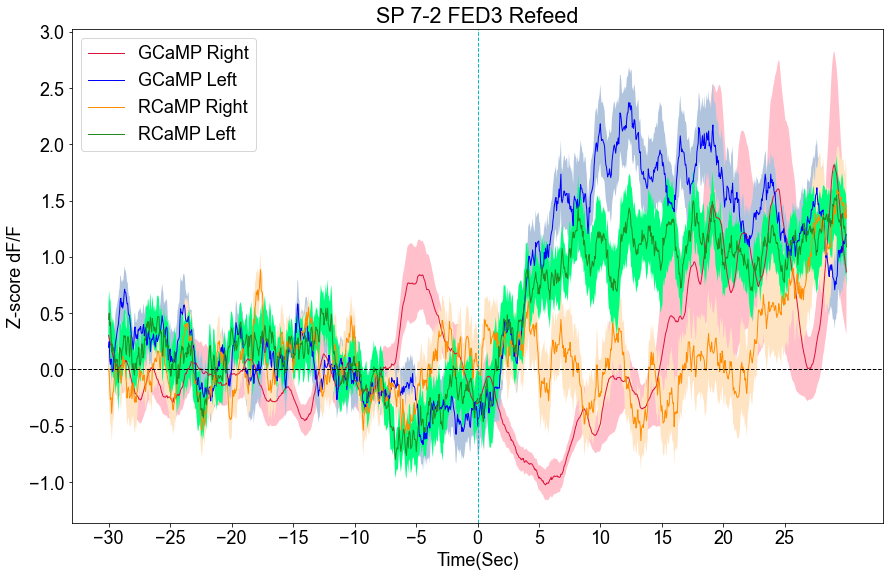

In [67]:
fig = plt.figure(figsize=(32, 20))
ax1 = fig.add_subplot(221)
ax1.plot(x,allgcamprighttrials['Mean'],'crimson',linewidth=1)
ax1.plot(x,allgcamplefttrials['Mean'],'blue',linewidth=1)

ax1.plot(x,allrcamprighttrials['Mean'],'darkorange',linewidth=1)
ax1.plot(x,allrcamplefttrials['Mean'],'forestgreen',linewidth=1)

ax1.set_xlabel('Time(Sec)')
ax1.set_ylabel('Z-score dF/F')
ax1.fill_between(x,allgcamprighttrialslowererror,allgcamprighttrialsuppererror, facecolor='pink')
ax1.fill_between(x,allgcamplefttrialslowererror,allgcamplefttrialsuppererror, facecolor='lightsteelblue')
ax1.fill_between(x,allrcamprighttrialslowererror,allrcamprighttrialsuppererror, facecolor='bisque')
ax1.fill_between(x,allrcamplefttrialslowererror,allrcamplefttrialsuppererror, facecolor='springgreen')


plt.axhline(0,0,1,linewidth=1,color='black',linestyle='--')
plt.axvline(0,0,1,linewidth=1,color='c',linestyle='--') #Reference keydown to find spot to place line
plt.legend(['GCaMP Right','GCaMP Left','RCaMP Right','RCaMP Left'])
plt.title("SP 7-2 FED3 Refeed")
plt.xticks(np.arange(-30, 30, step=5))
#plt.savefig('SP 7-7_38pellet_Refeed.png')